<a href="https://colab.research.google.com/github/imtiaz114/Brain_tumor_detection_from_2D_MRI_images/blob/main/Brain_tumor_detection_ML_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing data for Feature Extraction

## preparing the dataset folders(only once)

take all the yes and no images into separate folders and extract features from them

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#counting files
import os,glob,shutil

os.chdir('/content/drive/MyDrive/Dataset_2/dataset/no/')
count = 0
for f in glob.glob("*"):
  count += 1

print(count)

98


In [ ]:
#no need to run

count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/dataset/no/'

dim = (256,256)

os.chdir(dirpath)
filenames = os.listdir(dirpath)

dest_dir = '/content/drive/MyDrive/Dataset_2/ML_datasets/all_contour_no/256x256/'

for fname in filenames:
  img = cv2.imread(fname)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  dest = dest_dir + fname
  cv2.imwrite(dest,img)
  print(count)
  count += 1

## creating csv files with all features


In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from google.colab.patches import cv2_imshow
%matplotlib inline

from scipy.stats import skew
import scipy.stats as stats

from scipy.stats import kurtosis

import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data

import cv2
from google.colab.patches import cv2_imshow

In [ ]:
#load a file using opencv and give it as input in the following functions

from scipy.stats import skew
import scipy.stats as stats

from scipy.stats import kurtosis

def stat_features(mean,variance,std,skewness,img):
  im = img.flatten()

  m = np.mean(im)
  v = np.var(im)
  st = np.std(im)
  sk = np.absolute(skew(im))

  mean.append(m)
  variance.append(v)
  std.append(st)
  skewness.append(sk)

In [ ]:
#glcm features

def glcm_features(dissimilarity,correlation,asm,energy,homogeneity,contrast,gray_img):
  glcm = greycomatrix(gray_img, [5], [0], 256, symmetric=True, normed=True)

  dis = greycoprops(glcm, 'dissimilarity')[0, 0]
  corr = greycoprops(glcm, 'correlation')[0, 0]
  a = greycoprops(glcm, 'ASM')[0, 0]
  en = greycoprops(glcm, 'energy')[0, 0]
  hom = greycoprops(glcm, 'homogeneity')[0, 0]
  cont = greycoprops(glcm, 'contrast')[0, 0]

  dissimilarity.append(dis)
  correlation.append(corr)
  asm.append(a)
  energy.append(en)
  homogeneity.append(hom)
  contrast.append(cont)

In [ ]:
def coarseness(image, kmax):
	image = np.array(image)
	w = image.shape[0]
	h = image.shape[1]
	kmax = kmax if (np.power(2,kmax) < w) else int(np.log(w) / np.log(2))
	kmax = kmax if (np.power(2,kmax) < h) else int(np.log(h) / np.log(2))
	average_gray = np.zeros([kmax,w,h])
	horizon = np.zeros([kmax,w,h])
	vertical = np.zeros([kmax,w,h])
	Sbest = np.zeros([w,h])

	for k in range(kmax):
		window = np.power(2,k)
		for wi in range(w)[window:(w-window)]:
			for hi in range(h)[window:(h-window)]:
				average_gray[k][wi][hi] = np.sum(image[wi-window:wi+window, hi-window:hi+window])
		for wi in range(w)[window:(w-window-1)]:
			for hi in range(h)[window:(h-window-1)]:
				horizon[k][wi][hi] = average_gray[k][wi+window][hi] - average_gray[k][wi-window][hi]
				vertical[k][wi][hi] = average_gray[k][wi][hi+window] - average_gray[k][wi][hi-window]
		horizon[k] = horizon[k] * (1.0 / np.power(2, 2*(k+1)))
		vertical[k] = horizon[k] * (1.0 / np.power(2, 2*(k+1)))

	for wi in range(w):
		for hi in range(h):
			h_max = np.max(horizon[:,wi,hi])
			h_max_index = np.argmax(horizon[:,wi,hi])
			v_max = np.max(vertical[:,wi,hi])
			v_max_index = np.argmax(vertical[:,wi,hi])
			index = h_max_index if (h_max > v_max) else v_max_index
			Sbest[wi][hi] = np.power(2,index)

	fcrs = np.mean(Sbest)
	return fcrs

In [ ]:
def directionality(image):
	image = np.array(image, dtype = 'int64')
	h = image.shape[0]
	w = image.shape[1]
	convH = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
	convV = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
	deltaH = np.zeros([h,w])
	deltaV = np.zeros([h,w])
	theta = np.zeros([h,w])

	# calc for deltaH
	for hi in range(h)[1:h-1]:
		for wi in range(w)[1:w-1]:
			deltaH[hi][wi] = np.sum(np.multiply(image[hi-1:hi+2, wi-1:wi+2], convH))
	for wi in range(w)[1:w-1]:
		deltaH[0][wi] = image[0][wi+1] - image[0][wi]
		deltaH[h-1][wi] = image[h-1][wi+1] - image[h-1][wi]
	for hi in range(h):
		deltaH[hi][0] = image[hi][1] - image[hi][0]
		deltaH[hi][w-1] = image[hi][w-1] - image[hi][w-2]

	# calc for deltaV
	for hi in range(h)[1:h-1]:
		for wi in range(w)[1:w-1]:
			deltaV[hi][wi] = np.sum(np.multiply(image[hi-1:hi+2, wi-1:wi+2], convV))
	for wi in range(w):
		deltaV[0][wi] = image[1][wi] - image[0][wi]
		deltaV[h-1][wi] = image[h-1][wi] - image[h-2][wi]
	for hi in range(h)[1:h-1]:
		deltaV[hi][0] = image[hi+1][0] - image[hi][0]
		deltaV[hi][w-1] = image[hi+1][w-1] - image[hi][w-1]

	deltaG = (np.absolute(deltaH) + np.absolute(deltaV)) / 2.0
	deltaG_vec = np.reshape(deltaG, (deltaG.shape[0] * deltaG.shape[1]))

	# calc the theta
	for hi in range(h):
		for wi in range(w):
			if (deltaH[hi][wi] == 0 and deltaV[hi][wi] == 0):
				theta[hi][wi] = 0;
			elif(deltaH[hi][wi] == 0):
				theta[hi][wi] = np.pi
			else:
				theta[hi][wi] = np.arctan(deltaV[hi][wi] / deltaH[hi][wi]) + np.pi / 2.0
	theta_vec = np.reshape(theta, (theta.shape[0] * theta.shape[1]))

	n = 16
	t = 12
	cnt = 0
	hd = np.zeros(n)
	dlen = deltaG_vec.shape[0]
	for ni in range(n):
		for k in range(dlen):
			if((deltaG_vec[k] >= t) and (theta_vec[k] >= (2*ni-1) * np.pi / (2 * n)) and (theta_vec[k] < (2*ni+1) * np.pi / (2 * n))):
				hd[ni] += 1
	hd = hd / np.mean(hd)
	hd_max_index = np.argmax(hd)
	fdir = 0
	for ni in range(n):
		fdir += np.power((ni - hd_max_index), 2) * hd[ni]
	return fdir

In [ ]:
def roughness(fcrs, fcon):
	return fcrs + fcon

In [ ]:
#creating list for all of the features
import os,glob
count = 0
dirpath = '/content/drive/MyDrive/Dataset_2/ML_datasets/all_contour_yes/224x224/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

dissimilarity = []
correlation = []
asm = []
energy = []
homogeneity = []
contrast = []

mean = []
std = []
skewness = []
variance = []

fcrs = []
fr = []
fdir = []

image_title = []
image_label = []


for fname in filenames:
  image_title.append(fname)
  image_label.append(1)

  
  img = cv2.imread(fname)
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


  stat_features(mean,variance,std,skewness,img)
  glcm_features(dissimilarity,correlation,asm,energy,homogeneity,contrast,gray_img)

  fcrs.append(coarseness(gray_img, 5))
  fr.append(roughness(fcrs[count], contrast[count]))
  fdir.append(directionality(gray_img))

  print(count)
  count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


In [ ]:
dirpath = '/content/drive/MyDrive/Dataset_2/ML_datasets/all_contour_no/224x224/'

os.chdir(dirpath)
filenames = os.listdir(dirpath)

for fname in filenames:
  image_title.append(fname)
  image_label.append(0)


  img = cv2.imread(fname)
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


  stat_features(mean,variance,std,skewness,img)
  glcm_features(dissimilarity,correlation,asm,energy,homogeneity,contrast,gray_img)

  fcrs.append(coarseness(gray_img, 5))
  fr.append(roughness(fcrs[count], contrast[count]))
  fdir.append(directionality(gray_img))

  print(count)
  count += 1

155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252


In [ ]:
#for identifying negative values in features
#the training won't work for negative values
(np.array(skewness) < 0).any()

False

In [ ]:
# Import packages
import numpy as np
import pandas as pd# Update default settings to show 2 decimal place
pd.options.display.float_format = '{:.2f}'.format# Create a small dataframe
df = pd.DataFrame({'Image': image_title,
                   'Class': image_label,
                   'Mean': mean,
                   'Standard Deviation': std,
                   'Variance': variance,
                   'Skewness': skewness,
                   'Contrast': contrast,
                   'Homogeneity': homogeneity,
                   'Energy': energy,
                   'ASM': asm,
                   'Correlation': correlation,
                   'Dissimilarity': dissimilarity,
                   #'Roughness': fr,
                   #'coarseness': fcrs,
                   'Directionality':fdir ,
                   })
df

,Image,Class,Mean,Standard Deviation,Variance,Skewness,Contrast,Homogeneity,Energy,ASM,Correlation,Dissimilarity,Directionality
0,Y62.png,1,37.97,41.86,1752.62,1.33,1181.18,0.29,0.10,0.01,0.63,16.36,287.28
1,Y64.png,1,63.39,62.66,3926.04,0.58,2007.88,0.33,0.28,0.08,0.73,23.33,331.88
2,Y68.png,1,44.65,40.41,1632.79,0.87,793.93,0.21,0.07,0.01,0.73,14.46,300.52
3,Y71.png,1,67.60,55.19,3046.11,0.75,1215.17,0.24,0.11,0.01,0.79,18.68,342.26
4,Y73.png,1,45.56,56.16,3154.18,1.53,1124.57,0.31,0.24,0.06,0.82,18.12,391.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,21 no.jpg,0,48.05,56.53,3195.70,1.42,1428.90,0.38,0.21,0.04,0.78,19.57,300.72
249,no 1.jpg,0,29.74,35.44,1256.32,1.17,943.45,0.37,0.20,0.04,0.63,14.93,307.34
250,46 no.jpg,0,56.21,66.73,4453.45,0.68,1355.42,0.48,0.44,0.19,0.85,18.06,1155.65
251,no 89.jpg,0,36.87,37.80,1429.12,0.54,474.82,0.31,0.13,0.02,0.83,10.48,285.73


In [ ]:
df.head()

,Image,Class,Mean,Standard Deviation,Variance,Skewness,Contrast,Homogeneity,Energy,ASM,Correlation,Dissimilarity,Directionality
0,Y62.png,1,37.97,41.86,1752.62,1.33,1181.18,0.29,0.10,0.01,0.63,16.36,287.28
1,Y64.png,1,63.39,62.66,3926.04,0.58,2007.88,0.33,0.28,0.08,0.73,23.33,331.88
2,Y68.png,1,44.65,40.41,1632.79,0.87,793.93,0.21,0.07,0.01,0.73,14.46,300.52
3,Y71.png,1,67.60,55.19,3046.11,0.75,1215.17,0.24,0.11,0.01,0.79,18.68,342.26
4,Y73.png,1,45.56,56.16,3154.18,1.53,1124.57,0.31,0.24,0.06,0.82,18.12,391.87


In [ ]:
df.columns

Index(['Image', 'Class', 'Mean', 'Standard Deviation', 'Variance', 'Skewness',
       'Contrast', 'Homogeneity', 'Energy', 'ASM', 'Correlation',
       'Dissimilarity', 'Directionality'],
      dtype='object')

In [ ]:
# saving the dataframe
df.to_csv('/content/drive/MyDrive/Dataset_2/ML_datasets/feature_224x224.csv')

# Feature extraction

## imports

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 96 kB 4.4 MB/s 


In [ ]:
### All python libraries imported

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from matplotlib.pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict,GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,classification_report
from sklearn.metrics import mean_absolute_error

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from keras.layers import Dense, Dropout
from keras.models import Sequential

In [ ]:
#reading the csv file
csv_path = '/content/drive/MyDrive/Dataset_2/ML_datasets/feature_224x224.csv'
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,Image,Class,Mean,Standard Deviation,Variance,Skewness,Contrast,Homogeneity,Energy,ASM,Correlation,Dissimilarity,Directionality
0,0,Y62.png,1,37.97,41.86,1752.62,1.33,1181.18,0.29,0.10,0.01,0.63,16.36,287.28
1,1,Y64.png,1,63.39,62.66,3926.04,0.58,2007.88,0.33,0.28,0.08,0.73,23.33,331.88
2,2,Y68.png,1,44.65,40.41,1632.79,0.87,793.93,0.21,0.07,0.01,0.73,14.46,300.52
3,3,Y71.png,1,67.60,55.19,3046.11,0.75,1215.17,0.24,0.11,0.01,0.79,18.68,342.26
4,4,Y73.png,1,45.56,56.16,3154.18,1.53,1124.57,0.31,0.24,0.06,0.82,18.12,391.87


In [ ]:
# deleting the first column because its not important
df = df.iloc[: , 1:]
df.head()

,Image,Class,Mean,Standard Deviation,Variance,Skewness,Contrast,Homogeneity,Energy,ASM,Correlation,Dissimilarity,Directionality
0,Y62.png,1,37.97,41.86,1752.62,1.33,1181.18,0.29,0.10,0.01,0.63,16.36,287.28
1,Y64.png,1,63.39,62.66,3926.04,0.58,2007.88,0.33,0.28,0.08,0.73,23.33,331.88
2,Y68.png,1,44.65,40.41,1632.79,0.87,793.93,0.21,0.07,0.01,0.73,14.46,300.52
3,Y71.png,1,67.60,55.19,3046.11,0.75,1215.17,0.24,0.11,0.01,0.79,18.68,342.26
4,Y73.png,1,45.56,56.16,3154.18,1.53,1124.57,0.31,0.24,0.06,0.82,18.12,391.87


In [ ]:
df.shape

(253, 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image               253 non-null    object 
 1   Class               253 non-null    int64  
 2   Mean                253 non-null    float64
 3   Standard Deviation  253 non-null    float64
 4   Variance            253 non-null    float64
 5   Skewness            253 non-null    float64
 6   Contrast            253 non-null    float64
 7   Homogeneity         253 non-null    float64
 8   Energy              253 non-null    float64
 9   ASM                 253 non-null    float64
 10  Correlation         253 non-null    float64
 11  Dissimilarity       253 non-null    float64
 12  Directionality      253 non-null    float64
dtypes: float64(11), int64(1), object(1)
memory usage: 25.8+ KB


In [ ]:
###  To find the missing values in every feature
df.isnull().sum()

Image                 0
Class                 0
Mean                  0
Standard Deviation    0
Variance              0
Skewness              0
Contrast              0
Homogeneity           0
Energy                0
ASM                   0
Correlation           0
Dissimilarity         0
Directionality        0
dtype: int64

In [ ]:
s = df['Class']
s.value_counts()

1    155
0     98
Name: Class, dtype: int64

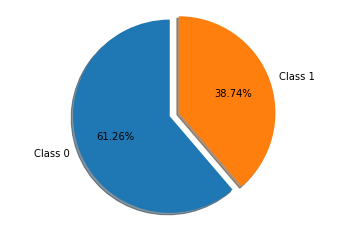

In [ ]:
### Pie Chart for Class attribute

labels = 'Class 0' , 'Class 1'
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(s.value_counts(), explode = explode ,labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [ ]:
### Dropping Image attribute
df.drop('Image',axis=1,inplace=True)

In [ ]:
### Correlation Matrix

corr_m = df.corr()
corr_m.style.background_gradient(cmap='coolwarm',axis=None).set_precision(2)

,Class,Mean,Standard Deviation,Variance,Skewness,Contrast,Homogeneity,Energy,ASM,Correlation,Dissimilarity,Directionality
Class,1.00,0.39,0.25,0.21,-0.26,0.10,-0.39,-0.31,-0.28,0.15,0.22,0.14
Mean,0.39,1.00,0.68,0.68,-0.65,0.59,-0.61,-0.47,-0.38,0.05,0.75,0.09
Standard Deviation,0.25,0.68,1.00,0.99,-0.40,0.74,-0.08,0.07,0.09,0.26,0.75,0.04
Variance,0.21,0.68,0.99,1.00,-0.40,0.73,-0.06,0.09,0.10,0.26,0.73,0.02
Skewness,-0.26,-0.65,-0.40,-0.40,1.00,-0.21,0.50,0.38,0.38,-0.29,-0.40,-0.11
Contrast,0.10,0.59,0.74,0.73,-0.21,1.00,-0.08,0.07,0.10,-0.41,0.91,-0.07
Homogeneity,-0.39,-0.61,-0.08,-0.06,0.50,-0.08,1.00,0.93,0.86,0.02,-0.39,-0.23
Energy,-0.31,-0.47,0.07,0.09,0.38,0.07,0.93,1.00,0.94,0.01,-0.19,-0.20
ASM,-0.28,-0.38,0.09,0.10,0.38,0.10,0.86,0.94,1.00,-0.01,-0.14,-0.19
Correlation,0.15,0.05,0.26,0.26,-0.29,-0.41,0.02,0.01,-0.01,1.00,-0.29,0.12


Class
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Mean, dtype: object

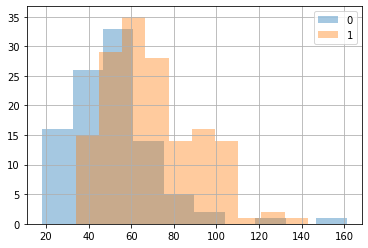

In [ ]:
### Comparing the distribution of 'Mean' wrt to Class 1 and Class 0
df.groupby('Class').Mean.hist(alpha=0.4,legend=True)

## Data Transformation

### 1. Handling the missing values

In [ ]:
###  To find the missing values in every feature
df.isnull().sum()

Class                 0
Mean                  0
Standard Deviation    0
Variance              0
Skewness              0
Contrast              0
Homogeneity           0
Energy                0
ASM                   0
Correlation           0
Dissimilarity         0
Directionality        0
dtype: int64

### 2. Data Cleansing : Outlier Detection and Removal

In [ ]:
# Setting an upper and lower limit for outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
# The function that examines whether there is an outlier according to the threshold values we have determined.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
for col in df.columns:
    print(col, check_outlier(df, col))

Class False
Mean True
Standard Deviation True
Variance True
Skewness True
Contrast True
Homogeneity True
Energy True
ASM True
Correlation True
Dissimilarity True
Directionality True


In [ ]:
# Replacing outliers with upper and lower limit
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
for col in df.columns:
        replace_with_thresholds(df, col)

In [ ]:
df.shape

(253, 12)

In [ ]:
for col in df.columns:
    print(col, check_outlier(df, col))

Class False
Mean False
Standard Deviation False
Variance False
Skewness False
Contrast False
Homogeneity False
Energy False
ASM False
Correlation True
Dissimilarity False
Directionality False


In [ ]:
#chceking for negative values
(df.values < 0).any()

False

In [ ]:
X = df.drop('Class',axis=1)   ### independent features
y = df['Class']               ### dependent features

## Dimensionality Reduction

### 1. Feature Selection

univariate selection

In [ ]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

In [ ]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [ ]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [ ]:
featureScores

,Specs,Score
0,Mean,322.56
1,Standard Deviation,42.63
2,Variance,7972.61
3,Skewness,4.37
4,Contrast,1102.28
5,Homogeneity,1.63
6,Energy,2.11
7,ASM,0.96
8,Correlation,0.08
9,Dissimilarity,18.28


### Feature Importance

In [ ]:
import matplotlib.pyplot as plt
model = ExtraTreesClassifier(criterion ='gini')
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[0.11921408 0.09330239 0.09235489 0.10080205 0.06666637 0.10310584
 0.08138347 0.08386488 0.08740459 0.07491872 0.09698273]


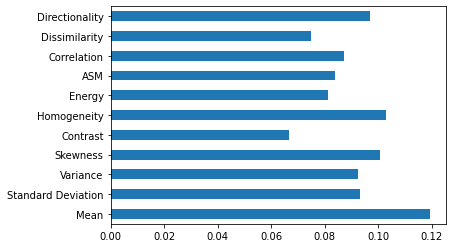

In [ ]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')
plt.show()

Interpreting from the above two techniques , we come to the conclusion that all of the features do affect the Class in a significant way. Hence we cannot drop the mentioned features

we can drop contrast and dissimilarity as they are least important

In [ ]:
X.drop('Contrast',axis=1,inplace=True)
X.drop('Dissimilarity',axis=1,inplace=True)

In [ ]:
X.head(2)

,Mean,Standard Deviation,Variance,Skewness,Homogeneity,Energy,ASM,Correlation,Directionality
0,37.97,41.86,1752.62,1.33,0.29,0.10,0.01,0.63,287.28
1,63.39,62.66,3926.04,0.58,0.33,0.28,0.08,0.73,331.88


### 2. Feature Extraction : Principal Component Analysis


In [ ]:
X.shape

(253, 9)

In [ ]:
X2 = X.copy()

In [ ]:
y2 = y.copy()

In [ ]:
from sklearn.decomposition import PCA
plt.style.use('ggplot')
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)
# The PCA model
pca = PCA(n_components=2) # estimate only 2 PCs
X_new = pca.fit_transform(X2) # project the original data into the PCA space

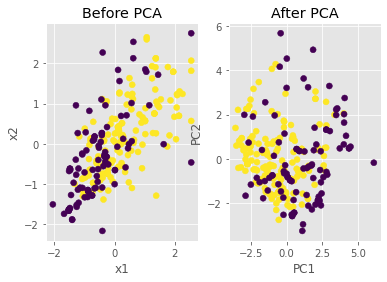

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(X2[:,0], X2[:,1], c=y2)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(X_new[:,0], X_new[:,1], c=y2)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()

In [ ]:
print(pca.explained_variance_ratio_)

[0.42485398 0.28098766]


In [ ]:
print(abs( pca.components_ ))

[[0.44559753 0.2489419  0.24757336 0.3681788  0.44653445 0.40300471
  0.3853244  0.09117501 0.15501286]
 [0.19322367 0.52435554 0.52420006 0.14411275 0.26435729 0.36316462
  0.37701224 0.21167462 0.05868555]]


### Feature Normalization(dataset splitting here)

80_20 split

In [ ]:
### Holdout Method : Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
X_train.shape

(202, 9)

In [ ]:
X_test.shape

(51, 9)

In [ ]:
y_train.shape

(202,)

In [ ]:
y_test.shape

(51,)

In [ ]:
scaler=StandardScaler()
### fit vs fit_transform
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train) , columns =X.columns )

In [ ]:
X_test_scaled=pd.DataFrame(scaler.transform(X_test) , columns =X.columns)

In [ ]:
X_train_scaled.head()

,Mean,Standard Deviation,Variance,Skewness,Homogeneity,Energy,ASM,Correlation,Directionality
0,2.08,1.23,1.25,-1.61,-0.93,-0.98,-0.84,-0.48,-0.59
1,-0.61,-0.50,-0.56,0.89,0.56,-0.22,-0.42,1.11,-0.76
2,-0.77,-1.31,-1.19,-1.49,-0.15,0.17,-0.05,1.30,0.17
3,-0.22,-1.19,-1.11,-0.77,0.01,-0.54,-0.65,0.11,-0.45
4,1.36,1.90,2.12,-0.93,-0.54,-0.62,-0.70,1.73,-0.34


In [ ]:
X_test_scaled.head()

,Mean,Standard Deviation,Variance,Skewness,Homogeneity,Energy,ASM,Correlation,Directionality
0,1.06,2.65,2.59,-0.93,0.61,1.17,1.40,0.17,-0.53
1,-0.91,-1.18,-1.10,1.44,-0.59,-0.73,-0.75,-1.02,2.04
2,-0.00,-0.68,-0.71,-1.80,-0.24,-0.18,-0.39,0.45,2.04
3,0.21,0.68,0.61,-0.91,-0.06,0.47,0.32,-1.50,1.39
4,0.64,0.09,-0.01,-1.63,0.03,0.13,-0.09,1.72,2.04


# Applying Algorithms on our scaled and transformed data

## 1. Naive Bayes Classifier

              precision    recall  f1-score   support

         0.0       0.63      0.52      0.57        23
         1.0       0.66      0.75      0.70        28

    accuracy                           0.65        51
   macro avg       0.64      0.64      0.64        51
weighted avg       0.65      0.65      0.64        51

Naive Bayes Test Accuracy :  64.70588235294117 %
Training Accuracy:  71.78217821782178 %

TP Rate :  0.75
TN Rate :  0.5217391304347826
FP Rate :  0.34375
FN Rate :  0.25
Success Rate:  0.6470588235294118
Misclassifiaction Rate:  0.35294117647058826


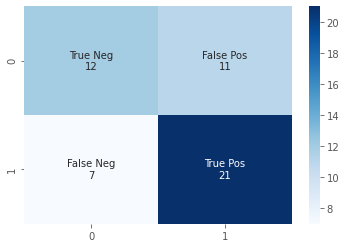

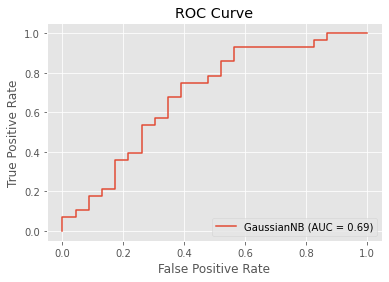

In [ ]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)

print(classification_report(y_test, y_pred_nb))

print('Naive Bayes Test Accuracy : ',accuracy_score(y_test, y_pred_nb)*100,'%')
print('Training Accuracy: ',accuracy_score(y_train, nb.predict(X_train_scaled))*100,'%')

cm_nb = confusion_matrix(y_test, y_pred_nb)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_nb.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm_nb,annot=labels,fmt='',cmap = 'Blues')
print()

TP_nb = cm_nb[1][1]
FP_nb = cm_nb[0][1]
FN_nb = cm_nb[1][0]
TN_nb = cm_nb[0][0] 

print('TP Rate : ',TP_nb / (TP_nb+FN_nb))
print('TN Rate : ', TN_nb/(FP_nb+TN_nb))
print('FP Rate : ', FP_nb/(FP_nb+TP_nb))
print('FN Rate : ', FN_nb/(FN_nb+TP_nb))
print('Success Rate: ', (TP_nb+TN_nb)/(TP_nb+FP_nb+FN_nb+TN_nb))
print('Misclassifiaction Rate: ', (FP_nb+FN_nb)/(TP_nb+FP_nb+FN_nb+TN_nb))

metrics.plot_roc_curve(nb, X_test_scaled, y_test) 
plt.title('ROC Curve')
plt.show()

## 2. K Nearest Neighbours

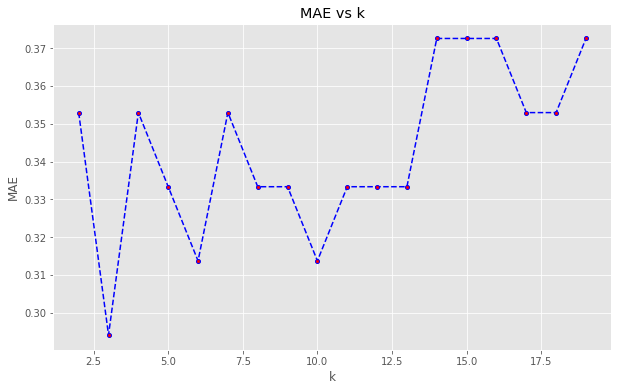



Value of k for which MAE is minimum :  2


In [ ]:


k_min  = 2
test_error_rate = []
k_array = []
MAE = 1

for k in range(2,20):
    
    model = KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled,y_train)
    predict_y = model.predict(X_test_scaled)
    y_true = y_test
    test_MAE = mean_absolute_error(y_true,predict_y)
    if test_MAE < MAE:
        MAE = test_MAE
        k1_min = k
    test_error_rate.append(test_MAE)
    k_array.append(k)
    
plt.figure(figsize=(10,6))
plt.plot(k_array,test_error_rate,'b',linestyle='dashed',marker='o',
         markerfacecolor='red', markersize=4)
plt.title('MAE vs k')
plt.xlabel('k')
plt.ylabel('MAE')
plt.show()
print('\n')
print("Value of k for which MAE is minimum : ",k_min)



WITH K=2

TP Rate :  0.6071428571428571
TN Rate :  0.6956521739130435
FP Rate :  0.2916666666666667
FN Rate :  0.39285714285714285
Success Rate:  0.6470588235294118
Misclassifiaction Rate:  0.35294117647058826
              precision    recall  f1-score   support

         0.0       0.59      0.70      0.64        23
         1.0       0.71      0.61      0.65        28

    accuracy                           0.65        51
   macro avg       0.65      0.65      0.65        51
weighted avg       0.66      0.65      0.65        51

KNN Test Accuracy :  64.70588235294117 %
Training Accuracy:  88.61386138613861 %


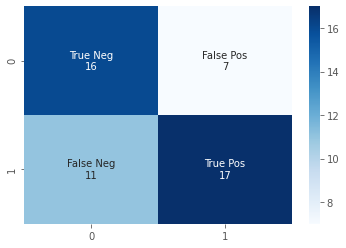

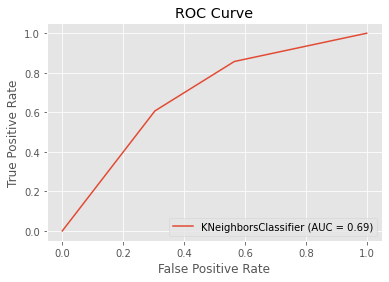

In [ ]:
# NOW WITH K=2
knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train_scaled,y_train)
pred_knn = knn.predict(X_test_scaled)

print('WITH K=2')
cm_knn = confusion_matrix(y_test, pred_knn)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_knn.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm_knn,annot=labels,fmt='',cmap='Blues')
print()

TP_knn = cm_knn[1][1]
FP_knn = cm_knn[0][1]
FN_knn = cm_knn[1][0]
TN_knn = cm_knn[0][0] 

print('TP Rate : ',TP_knn / (TP_knn+FN_knn))
print('TN Rate : ', TN_knn/(FP_knn+TN_knn))
print('FP Rate : ', FP_knn/(FP_knn+TP_knn))
print('FN Rate : ', FN_knn/(FN_knn+TP_knn))
print('Success Rate: ', (TP_knn+TN_knn)/(TP_knn+FP_knn+FN_knn+TN_knn))
print('Misclassifiaction Rate: ', (FP_knn+FN_knn)/(TP_knn+FP_knn+FN_knn+TN_knn))

print(classification_report(y_test,pred_knn))

print('KNN Test Accuracy : ',accuracy_score(y_test, pred_knn)*100,'%')
print('Training Accuracy: ',accuracy_score(y_train, knn.predict(X_train_scaled))*100,'%')

metrics.plot_roc_curve(knn, X_test_scaled, y_test) 
plt.title('ROC Curve')
plt.show()



## 3. Support Vector Machines

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


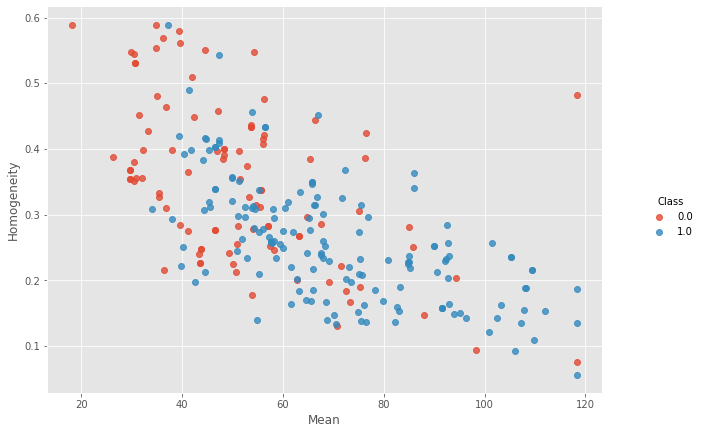

In [ ]:
sns.lmplot('Mean', 'Homogeneity', df, hue='Class', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.show()

### Using GridSearchCV for Hyperparameter Tuning for SVC¶

In [ ]:
classifier=SVC()

parameters = [{'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7,
                     2.0,1, 10, 100, 1000], 'kernel': ['linear']},
              
              {'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7,
                     2.0,1, 10, 100, 1000], 'kernel': ['rbf'],
               'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
              
              {'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7,
                     2.0,1, 10, 100, 1000], 'kernel': ['poly']}]
kfold = KFold(n_splits=10, random_state=21,shuffle=True)
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = kfold,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}



TP Rate :  0.8214285714285714
TN Rate :  0.6086956521739131
FP Rate :  0.28125
FN Rate :  0.17857142857142858
Success Rate:  0.7254901960784313
Misclassifiaction Rate:  0.27450980392156865
              precision    recall  f1-score   support

         0.0       0.74      0.61      0.67        23
         1.0       0.72      0.82      0.77        28

    accuracy                           0.73        51
   macro avg       0.73      0.72      0.72        51
weighted avg       0.73      0.73      0.72        51

SVC Test Accuracy :  72.54901960784314 %
Training Accuracy:  98.51485148514851 %


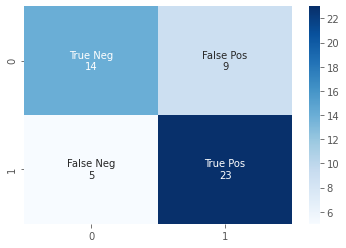

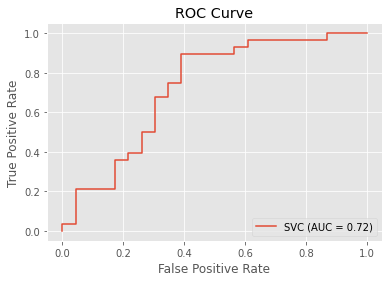

In [ ]:
classifier_svc = SVC(kernel = 'rbf',C = 100,gamma=0.1)
classifier_svc.fit(X_train_scaled, y_train)
y_pred_svc = classifier_svc.predict(X_test_scaled)

cm_svc = confusion_matrix(y_test, y_pred_svc)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_svc.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm_svc,annot=labels,fmt='',cmap='Blues')
print()

TP_svc = cm_svc[1][1]
FP_svc = cm_svc[0][1]
FN_svc = cm_svc[1][0]
TN_svc = cm_svc[0][0] 

print('TP Rate : ',TP_svc / (TP_svc+FN_svc))
print('TN Rate : ', TN_svc/(FP_svc+TN_svc))
print('FP Rate : ', FP_svc/(FP_svc+TP_svc))
print('FN Rate : ', FN_svc/(FN_svc+TP_svc))
print('Success Rate: ', (TP_svc+TN_svc)/(TP_svc+FP_svc+FN_svc+TN_svc))
print('Misclassifiaction Rate: ', (FP_svc+FN_svc)/(TP_svc+FP_svc+FN_svc+TN_svc))

print(classification_report(y_test,y_pred_svc))

print('SVC Test Accuracy : ',accuracy_score(y_test, y_pred_svc)*100,'%')
print('Training Accuracy: ',accuracy_score(y_train, classifier_svc.predict(X_train_scaled))*100,'%')

metrics.plot_roc_curve(classifier_svc, X_test_scaled, y_test) 
plt.title('ROC Curve')
plt.show()

## 4. Building A Neural Network

In [ ]:
model = Sequential()

input_dim = X_train_scaled.shape[1]

#add input layer 
model.add(Dense(units =256, activation = 'relu', input_dim = input_dim))
model.add(Dropout(0.4))

# hidden layer
model.add(Dense(units =75,activation = 'relu'))
model.add(Dropout(0.4))

#output layer
model.add(Dense(units = 1, activation = 'sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer = opt , loss ='binary_crossentropy', metrics = ['accuracy'])

model_history = model.fit(X_train_scaled, y_train,validation_split=0.20, batch_size = 64, epochs = 50)

Epoch 1/50
3/3 [==============================] - 17s 278ms/step - loss: 0.7483 - accuracy: 0.4556 - val_loss: 0.7273 - val_accuracy: 0.3415
Epoch 2/50
3/3 [==============================] - 0s 13ms/step - loss: 0.7008 - accuracy: 0.5499 - val_loss: 0.7193 - val_accuracy: 0.3659
Epoch 3/50
3/3 [==============================] - 0s 15ms/step - loss: 0.7081 - accuracy: 0.4291 - val_loss: 0.7119 - val_accuracy: 0.3902
Epoch 4/50
3/3 [==============================] - 0s 14ms/step - loss: 0.7263 - accuracy: 0.4981 - val_loss: 0.7048 - val_accuracy: 0.4878
Epoch 5/50
3/3 [==============================] - 0s 14ms/step - loss: 0.7113 - accuracy: 0.5063 - val_loss: 0.6979 - val_accuracy: 0.4878
Epoch 6/50
3/3 [==============================] - 0s 18ms/step - loss: 0.6859 - accuracy: 0.5572 - val_loss: 0.6911 - val_accuracy: 0.4878
Epoch 7/50
3/3 [==============================] - 0s 18ms/step - loss: 0.6967 - accuracy: 0.5382 - val_loss: 0.6844 - val_accuracy: 0.5366
Epoch 8/50
3/3 [=========


TP Rate :  0.7857142857142857
TN Rate :  0.5217391304347826
FP Rate :  0.3333333333333333
FN Rate :  0.21428571428571427
Success Rate:  0.6666666666666666
Misclassifiaction Rate:  0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.67      0.52      0.59        23
         1.0       0.67      0.79      0.72        28

    accuracy                           0.67        51
   macro avg       0.67      0.65      0.65        51
weighted avg       0.67      0.67      0.66        51

Neural Network Test Accuracy :  66.66666666666666 %


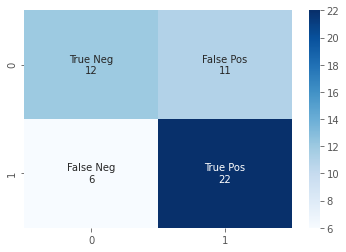

In [ ]:
y_pred_nn = model.predict(X_test_scaled)
y_pred_nn = (y_pred_nn > 0.5)

cm_nn = confusion_matrix(y_test, y_pred_nn)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_nn.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm_nn,annot=labels,fmt='',cmap='Blues')
print()


TP_nn = cm_nn[1][1]
FP_nn = cm_nn[0][1]
FN_nn = cm_nn[1][0]
TN_nn = cm_nn[0][0] 

print('TP Rate : ',TP_nn / (TP_nn+FN_nn))
print('TN Rate : ', TN_nn/(FP_nn+TN_nn))
print('FP Rate : ', FP_nn/(FP_nn+TP_nn))
print('FN Rate : ', FN_nn/(FN_nn+TP_nn))
print('Success Rate: ', (TP_nn+TN_nn)/(TP_nn+FP_nn+FN_nn+TN_nn))
print('Misclassifiaction Rate: ', (FP_nn+FN_nn)/(TP_nn+FP_nn+FN_nn+TN_nn))

print(classification_report(y_test,y_pred_nn))

print('Neural Network Test Accuracy : ',accuracy_score(y_test, y_pred_nn)*100,'%')

In [ ]:
print(model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


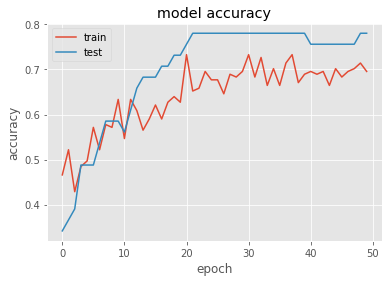

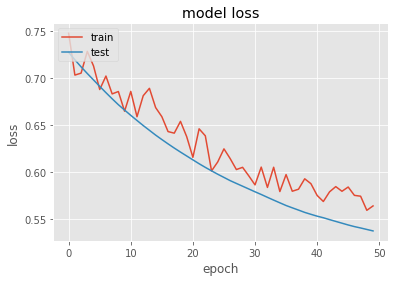

In [ ]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



## 5. Decision Tree Classifier

In [ ]:
tree = DecisionTreeClassifier(criterion='gini' ,random_state = 1)
tree.fit(X_train_scaled , y_train)
y_train_pred = tree.predict(X_train_scaled)
y_test_pred = tree.predict(X_test_scaled)

In [ ]:
print(accuracy_score(y_train,y_train_pred) , round(accuracy_score(y_test,y_test_pred),2))

1.0 0.76


[Text(2553.2727272727275, 2582.1, 'X[0] <= -0.259\ngini = 0.467\nsamples = 202\nvalue = [75, 127]'),
 Text(1420.3636363636365, 2310.3, 'X[8] <= -0.47\ngini = 0.475\nsamples = 98\nvalue = [60, 38]'),
 Text(676.3636363636364, 2038.5, 'X[0] <= -1.099\ngini = 0.382\nsamples = 66\nvalue = [49, 17]'),
 Text(541.0909090909091, 1766.6999999999998, 'gini = 0.0\nsamples = 21\nvalue = [21, 0]'),
 Text(811.6363636363637, 1766.6999999999998, 'X[0] <= -0.717\ngini = 0.47\nsamples = 45\nvalue = [28, 17]'),
 Text(405.81818181818187, 1494.8999999999999, 'X[8] <= -0.714\ngini = 0.457\nsamples = 17\nvalue = [6, 11]'),
 Text(270.54545454545456, 1223.1, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(541.0909090909091, 1223.1, 'X[4] <= 1.279\ngini = 0.337\nsamples = 14\nvalue = [3, 11]'),
 Text(405.81818181818187, 951.3, 'X[8] <= -0.511\ngini = 0.26\nsamples = 13\nvalue = [2, 11]'),
 Text(270.54545454545456, 679.5, 'X[7] <= -2.164\ngini = 0.153\nsamples = 12\nvalue = [1, 11]'),
 Text(135.27272727272728, 

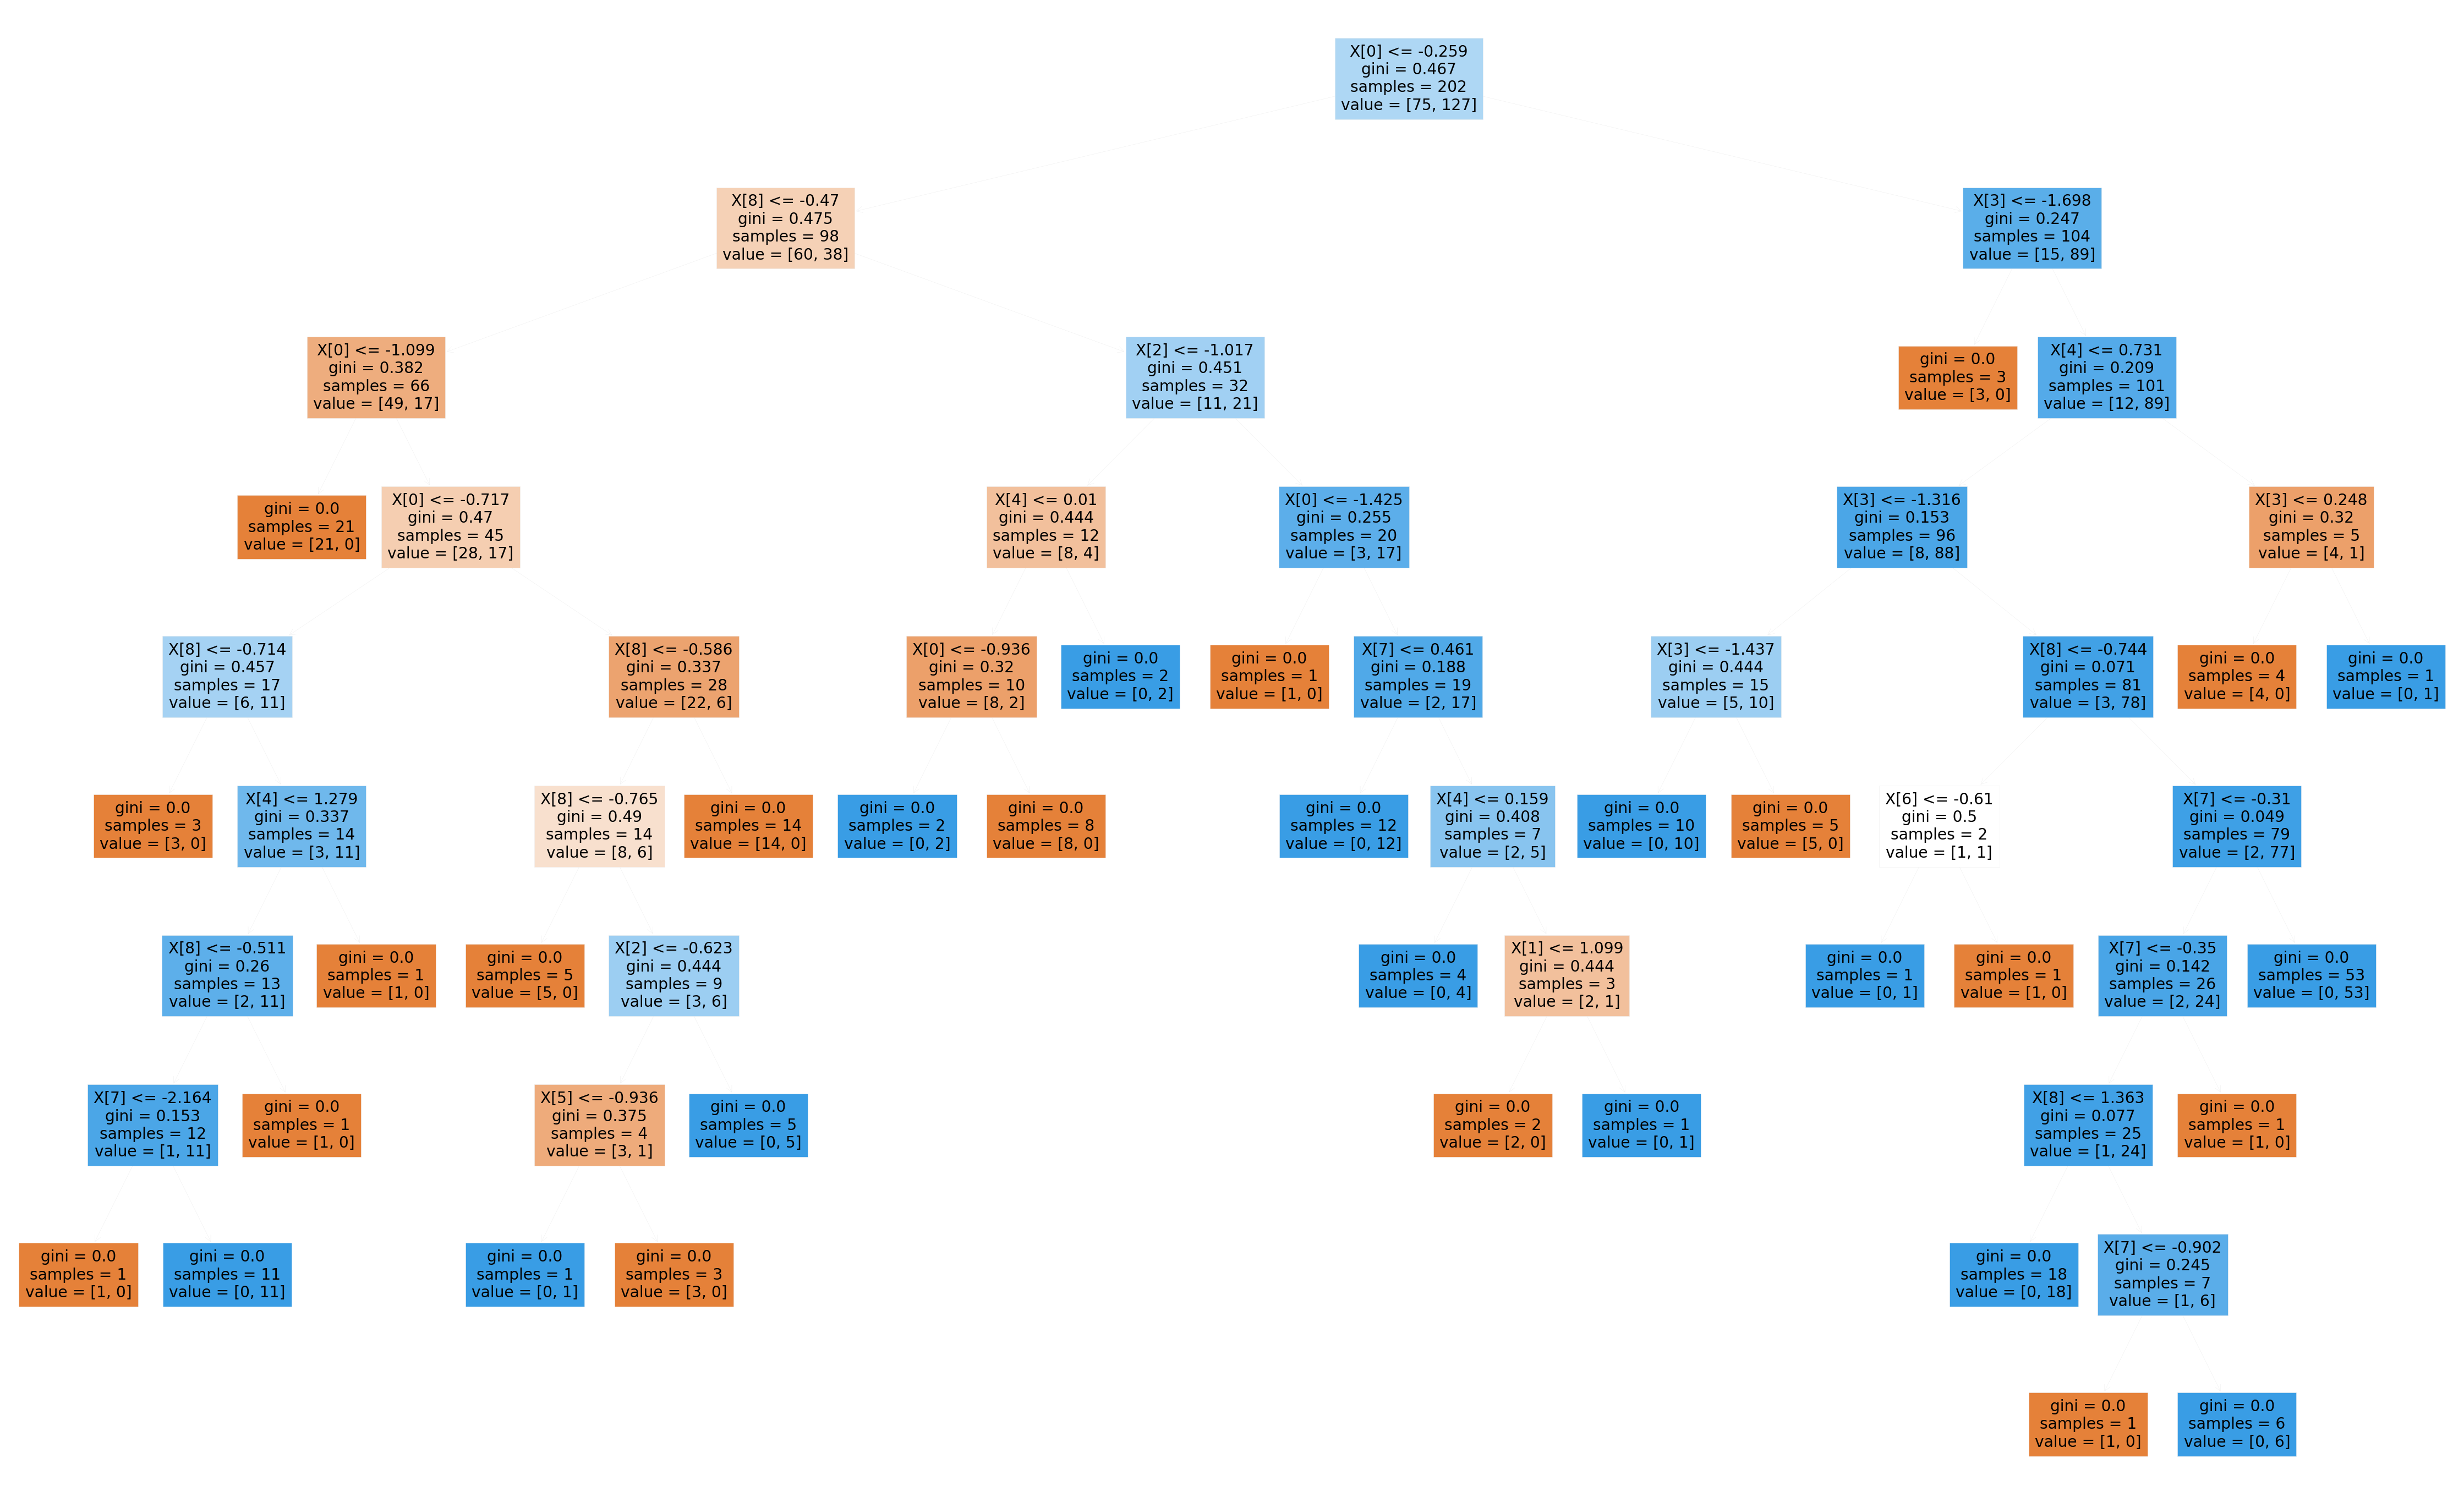

In [ ]:
rcParams['figure.figsize'] = 80,50
plot_tree(tree,filled=True)


By default, the Decision Tree function doesn’t perform any pruning and allows the tree to grow as much as it can. And thus overfitting occurs as can seen in the above image of our tree.

### Hyperparameter Tuning Using GridSearchCV

In [ ]:
param_dist = {
    "criterion" : ["gini" , "entropy"] , 
    "max_depth" : [1,2,3,4,5,6,7,8,9,10,None] , 
    "min_samples_split" : [10,20,50,80,100,200,300,500]
}
kfold = KFold(n_splits=10, random_state=21,shuffle=True)
grid_dt = GridSearchCV(tree , param_grid = param_dist , cv=kfold , n_jobs=-1)
grid_dt.fit(X_train_scaled,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=21, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
         

In [ ]:
grid_dt.best_params_

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 10}

TP Rate :  0.9285714285714286
TN Rate :  0.4782608695652174
FP Rate :  0.3157894736842105
FN Rate :  0.07142857142857142
Success Rate:  0.7254901960784313
Misclassifiaction Rate:  0.27450980392156865
              precision    recall  f1-score   support

         0.0       0.85      0.48      0.61        23
         1.0       0.68      0.93      0.79        28

    accuracy                           0.73        51
   macro avg       0.77      0.70      0.70        51
weighted avg       0.76      0.73      0.71        51

Decision Tree Test Accuracy :  72.54901960784314 %
Training Accuracy:  95.04950495049505 %


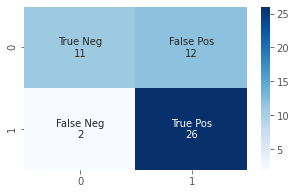

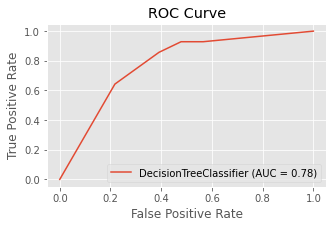

In [ ]:
rcParams['figure.figsize'] = 5,3
tree2 = DecisionTreeClassifier(criterion='gini', max_depth= 6 , min_samples_split=10)
tree2.fit(X_train_scaled , y_train)
y_pred_dt = tree2.predict(X_test_scaled)

cm_dt = confusion_matrix(y_test, y_pred_dt)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_dt.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_dt,annot=labels,fmt='',cmap='Blues')

TP_dt = cm_dt[1][1]
FP_dt = cm_dt[0][1]
FN_dt = cm_dt[1][0]
TN_dt = cm_dt[0][0] 

print('TP Rate : ',TP_dt / (TP_dt+FN_dt))
print('TN Rate : ', TN_dt/(FP_dt+TN_dt))
print('FP Rate : ', FP_dt/(FP_dt+TP_dt))
print('FN Rate : ', FN_dt/(FN_dt+TP_dt))
print('Success Rate: ', (TP_dt+TN_dt)/(TP_dt+FP_dt+FN_dt+TN_dt))
print('Misclassifiaction Rate: ', (FP_dt+FN_dt)/(TP_dt+FP_dt+FN_dt+TN_dt))

print(classification_report(y_test,y_pred_dt))

print('Decision Tree Test Accuracy : ',accuracy_score(y_test, y_pred_dt)*100,'%')
print('Training Accuracy: ',accuracy_score(y_train, tree2.predict(X_train_scaled))*100,'%')

metrics.plot_roc_curve(tree2, X_test_scaled, y_test) 
plt.title('ROC Curve')
plt.show()

[Text(2575.3846153846152, 2523.8571428571427, 'X[0] <= -0.259\ngini = 0.467\nsamples = 202\nvalue = [75, 127]'),
 Text(1545.230769230769, 2135.5714285714284, 'X[8] <= -0.47\ngini = 0.475\nsamples = 98\nvalue = [60, 38]'),
 Text(686.7692307692307, 1747.2857142857142, 'X[0] <= -1.099\ngini = 0.382\nsamples = 66\nvalue = [49, 17]'),
 Text(515.0769230769231, 1359.0, 'gini = 0.0\nsamples = 21\nvalue = [21, 0]'),
 Text(858.4615384615383, 1359.0, 'X[0] <= -0.717\ngini = 0.47\nsamples = 45\nvalue = [28, 17]'),
 Text(515.0769230769231, 970.7142857142858, 'X[4] <= 1.24\ngini = 0.457\nsamples = 17\nvalue = [6, 11]'),
 Text(343.38461538461536, 582.4285714285716, 'X[3] <= 1.24\ngini = 0.337\nsamples = 14\nvalue = [3, 11]'),
 Text(171.69230769230768, 194.14285714285734, 'gini = 0.153\nsamples = 12\nvalue = [1, 11]'),
 Text(515.0769230769231, 194.14285714285734, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(686.7692307692307, 582.4285714285716, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(12

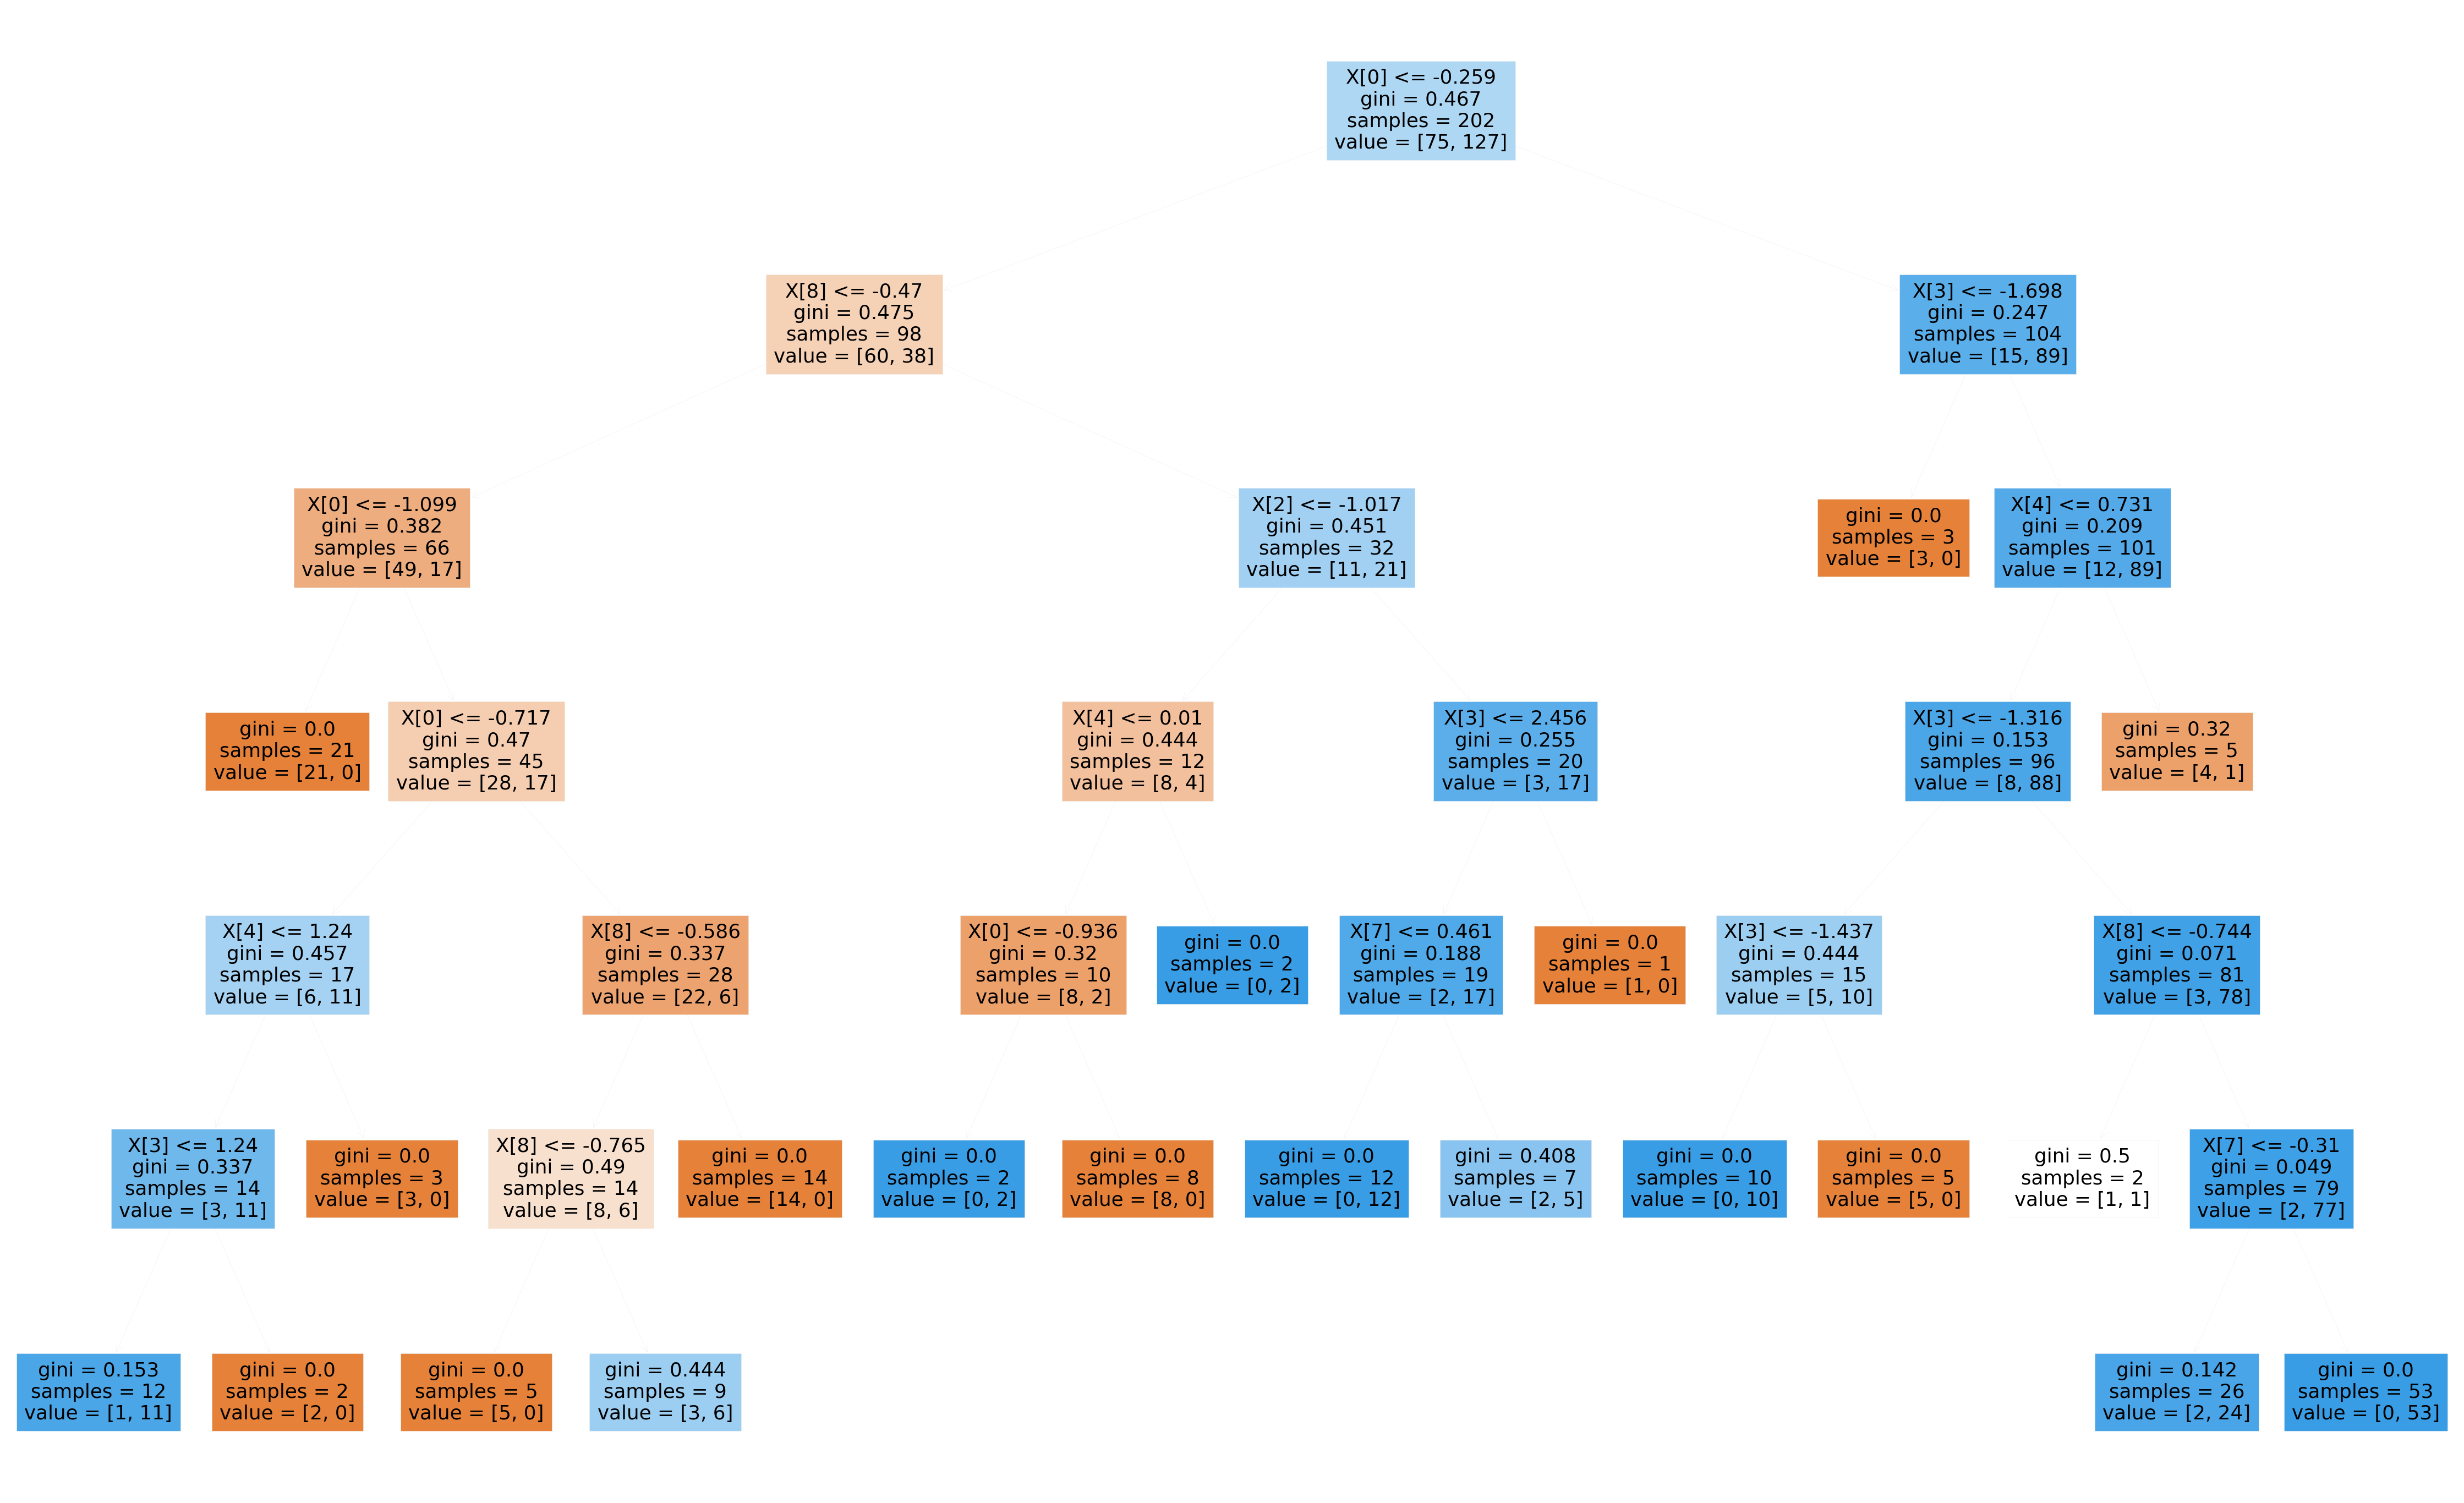

In [ ]:
rcParams['figure.figsize'] = 80,50
plot_tree(tree2,filled=True)

## 6. Tree Ensembles

### 6.1 Bagging

In [ ]:
bag = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    max_features=0.5,
    n_estimators=50,
    max_samples=0.5,
    bootstrap=True,
    oob_score=True,
)
bag.fit(X_train_scaled,y_train)
print('OOB Score without hyperparameter tuning : ',(bag.oob_score_)*100,'%')

OOB Score without hyperparameter tuning :  81.68316831683168 %


In [ ]:
parameters = {
    'n_estimators': [50,100,500], 
    'max_samples': [0.1,0.2,0.4,0.7,1.0],
    'bootstrap' : [True,False],
    'max_features' : [0.1,0.2,0.4,0.7,1.0]
    }
kfold = KFold(n_splits=10, random_state=21,shuffle=True)
search = GridSearchCV(bag, parameters, cv=kfold,verbose = 1 , n_jobs=-1)
search.fit(X_train_scaled,y_train)
search.best_params_



Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  4.4min finished


{'bootstrap': True,
 'max_features': 0.4,
 'max_samples': 1.0,
 'n_estimators': 100}

OOB Score with hyperparameter tuning :  83.16831683168317 %

TP Rate :  0.9642857142857143
TN Rate :  0.6086956521739131
FP Rate :  0.25
FN Rate :  0.03571428571428571
Success Rate:  0.803921568627451
Misclassifiaction Rate:  0.19607843137254902
              precision    recall  f1-score   support

         0.0       0.93      0.61      0.74        23
         1.0       0.75      0.96      0.84        28

    accuracy                           0.80        51
   macro avg       0.84      0.79      0.79        51
weighted avg       0.83      0.80      0.80        51

Bagging Test Accuracy :  80.3921568627451 %
Training Accuracy:  100.0 %


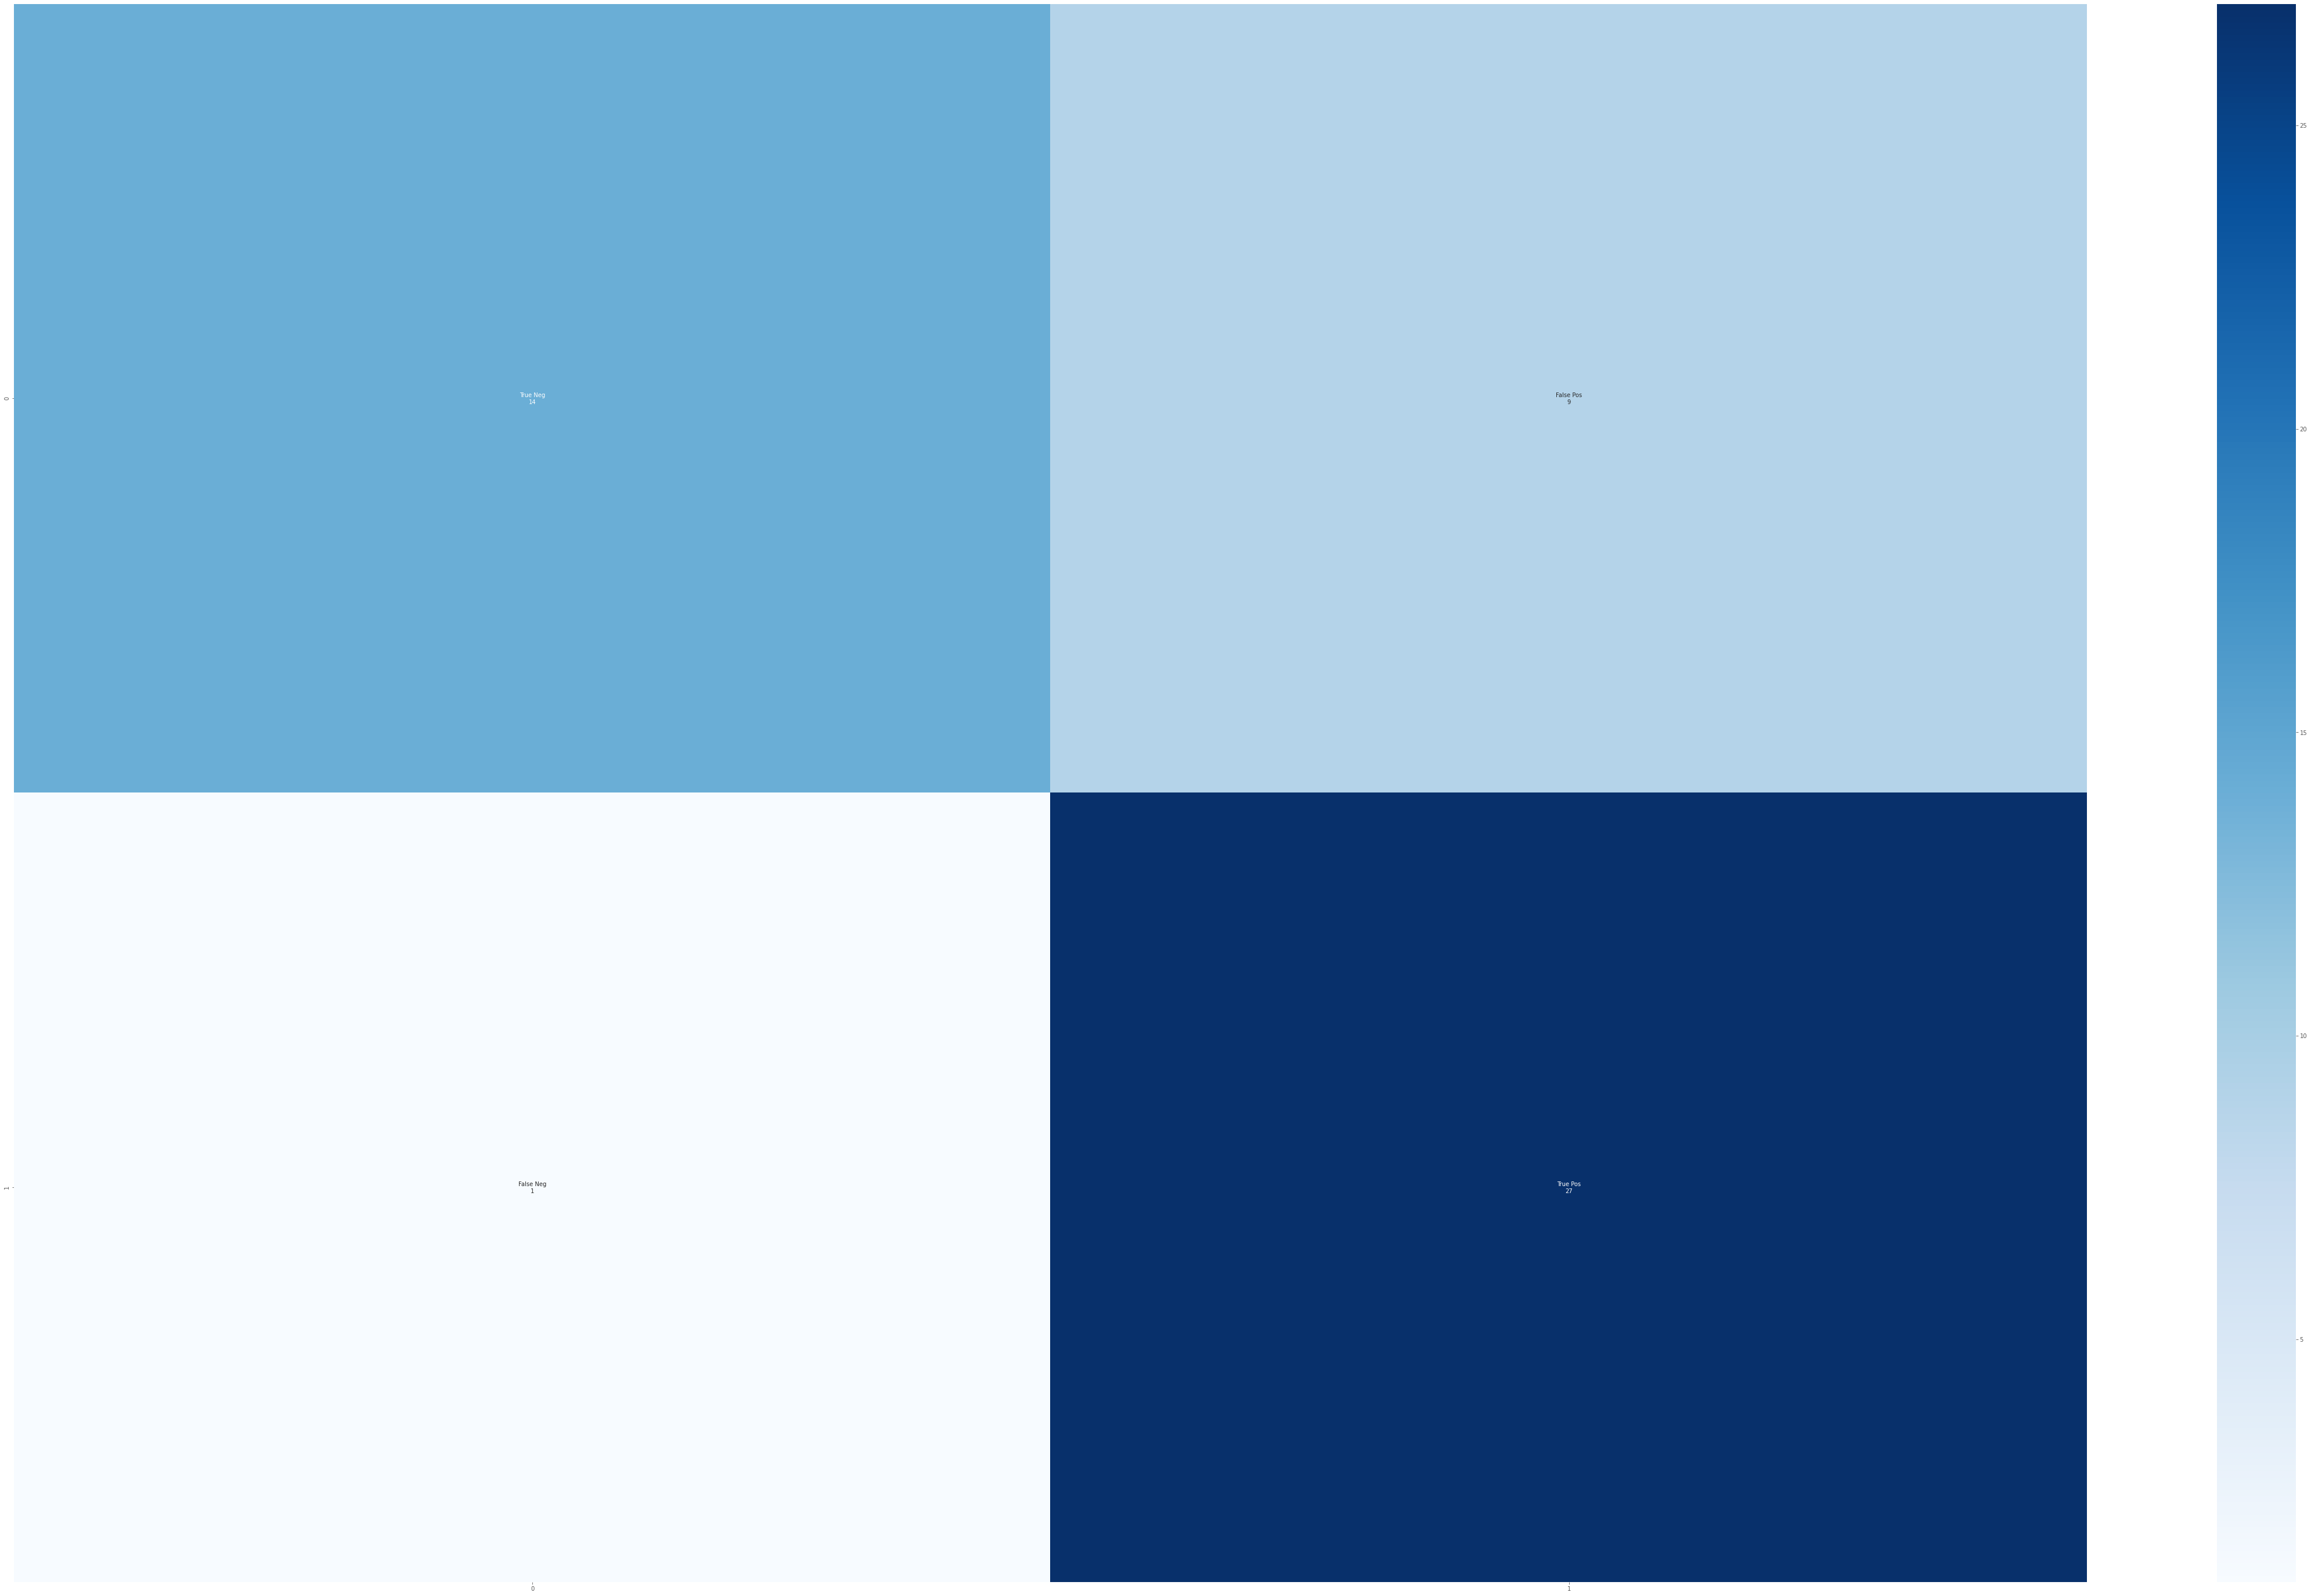

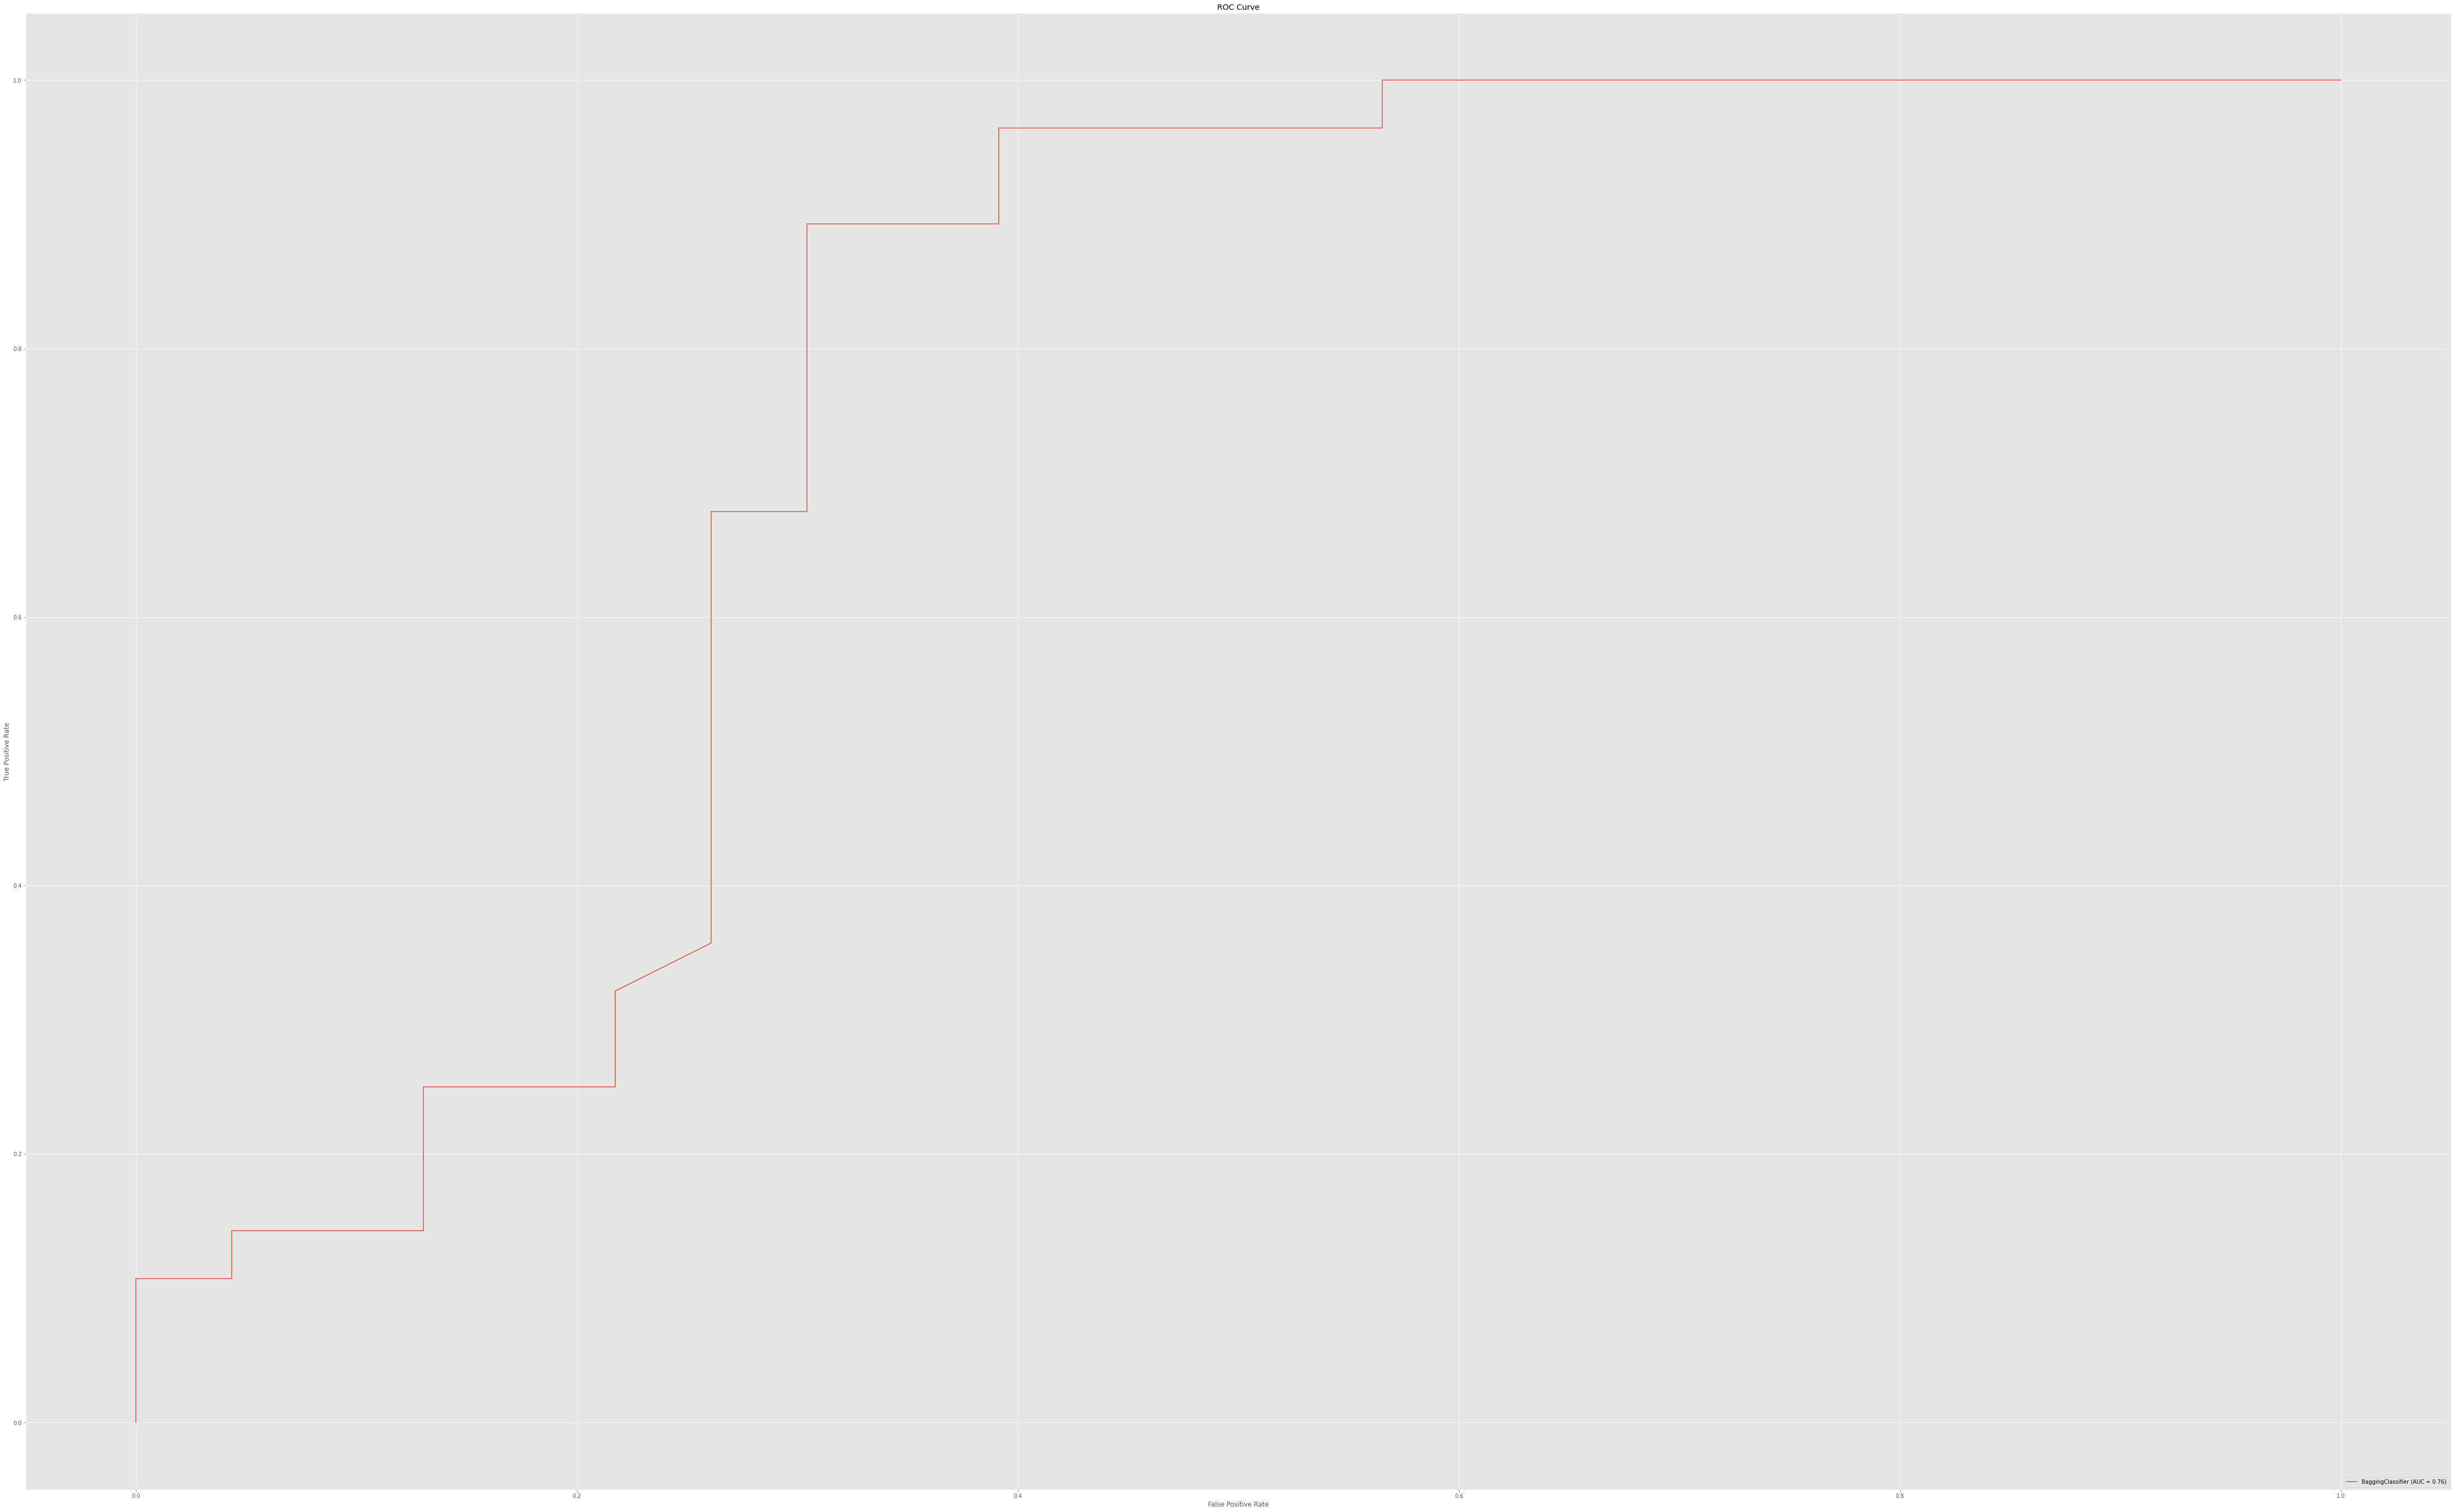

In [ ]:
bag2 = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    max_features=0.4,
    n_estimators=500,
    max_samples=1.0,
    bootstrap=True,
    oob_score=True,
)

bag2.fit(X_train_scaled,y_train)
y_pred_bag = bag2.predict(X_test_scaled)
print('OOB Score with hyperparameter tuning : ',(bag2.oob_score_)*100,'%')

cm_bag = confusion_matrix(y_test, y_pred_bag)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_bag.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_bag,annot=labels,fmt='',cmap='Blues')
print()

TP_bag = cm_bag[1][1]
FP_bag = cm_bag[0][1]
FN_bag = cm_bag[1][0]
TN_bag = cm_bag[0][0] 

print('TP Rate : ',TP_bag / (TP_bag+FN_bag))
print('TN Rate : ', TN_bag/(FP_bag+TN_bag))
print('FP Rate : ', FP_bag/(FP_bag+TP_bag))
print('FN Rate : ', FN_bag/(FN_bag+TP_bag))
print('Success Rate: ', (TP_bag+TN_bag)/(TP_bag+FP_bag+FN_bag+TN_bag))
print('Misclassifiaction Rate: ', (FP_bag+FN_bag)/(TP_bag+FP_bag+FN_bag+TN_bag))

print(classification_report(y_test, y_pred_bag))

print('Bagging Test Accuracy : ',accuracy_score(y_test, y_pred_bag)*100,'%')
print('Training Accuracy: ',accuracy_score(y_train, bag2.predict(X_train_scaled))*100,'%')

metrics.plot_roc_curve(bag2, X_test_scaled, y_test) 
plt.title('ROC Curve')
plt.show()

### 6.2 Random Forest

In [ ]:
rf = RandomForestClassifier(bootstrap = True ,
                            n_estimators = 50,
                            max_features = 0.5,
                            criterion='entropy', 
                            max_depth= None, 
                            min_samples_split=10)
rf.fit(X_train_scaled , y_train)
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

print(accuracy_score(y_train,y_train_pred_rf)*100 , round(accuracy_score(y_test,y_test_pred_rf),2)*100)

97.52475247524752 80.0


In [ ]:
rf_params = {
    'n_estimators': [50,100,200],
    "max_depth": [1,2,3,4,5,6,7,8,9,10,None],
    "min_samples_split" : [10,20,50,80,100,200,300]#,500],#onk time lage
    'bootstrap' : [True,False],
    'max_features' : [0.1,0.2,0.4,0.7,1.0],
    'criterion' : ['gini','entropy']
    
}

search_rf = GridSearchCV(rf, rf_params, cv=5,verbose = 1 , n_jobs=-1)
search_rf.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 5280 candidates, totalling 26400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2488 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 3588 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 6388 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 8088 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 9988 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 12088 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 14388 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done 16888 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 19588 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 22488 tasks  

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=0.5,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,...
                                              warm_start=False),
             iid='deprecated', n_jobs=-1,
    

In [ ]:
GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy',
                                              max_features=0.5,
                                              min_samples_split=10,
                                              n_estimators=50),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                         'max_features': [0.1, 0.2, 0.4, 0.7, 1.0],
                         'min_samples_split': [10, 20, 50, 80, 100, 200, 300,
                                               500],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=0.5,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,...
                                              warm_start=False),
             iid='deprecated', n_jobs=-1,
    

In [ ]:
search_rf.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.2,
 'min_samples_split': 10,
 'n_estimators': 100}


TP Rate :  0.9642857142857143
TN Rate :  0.6086956521739131
FP Rate :  0.25
FN Rate :  0.03571428571428571
Success Rate:  0.803921568627451
Misclassifiaction Rate:  0.19607843137254902
              precision    recall  f1-score   support

         0.0       0.93      0.61      0.74        23
         1.0       0.75      0.96      0.84        28

    accuracy                           0.80        51
   macro avg       0.84      0.79      0.79        51
weighted avg       0.83      0.80      0.80        51

OOB Score with hyperparameter tuning :  78.21782178217822 %
Random Forest Test Accuracy :  80.3921568627451 %
Training Accuracy:  97.52475247524752 %


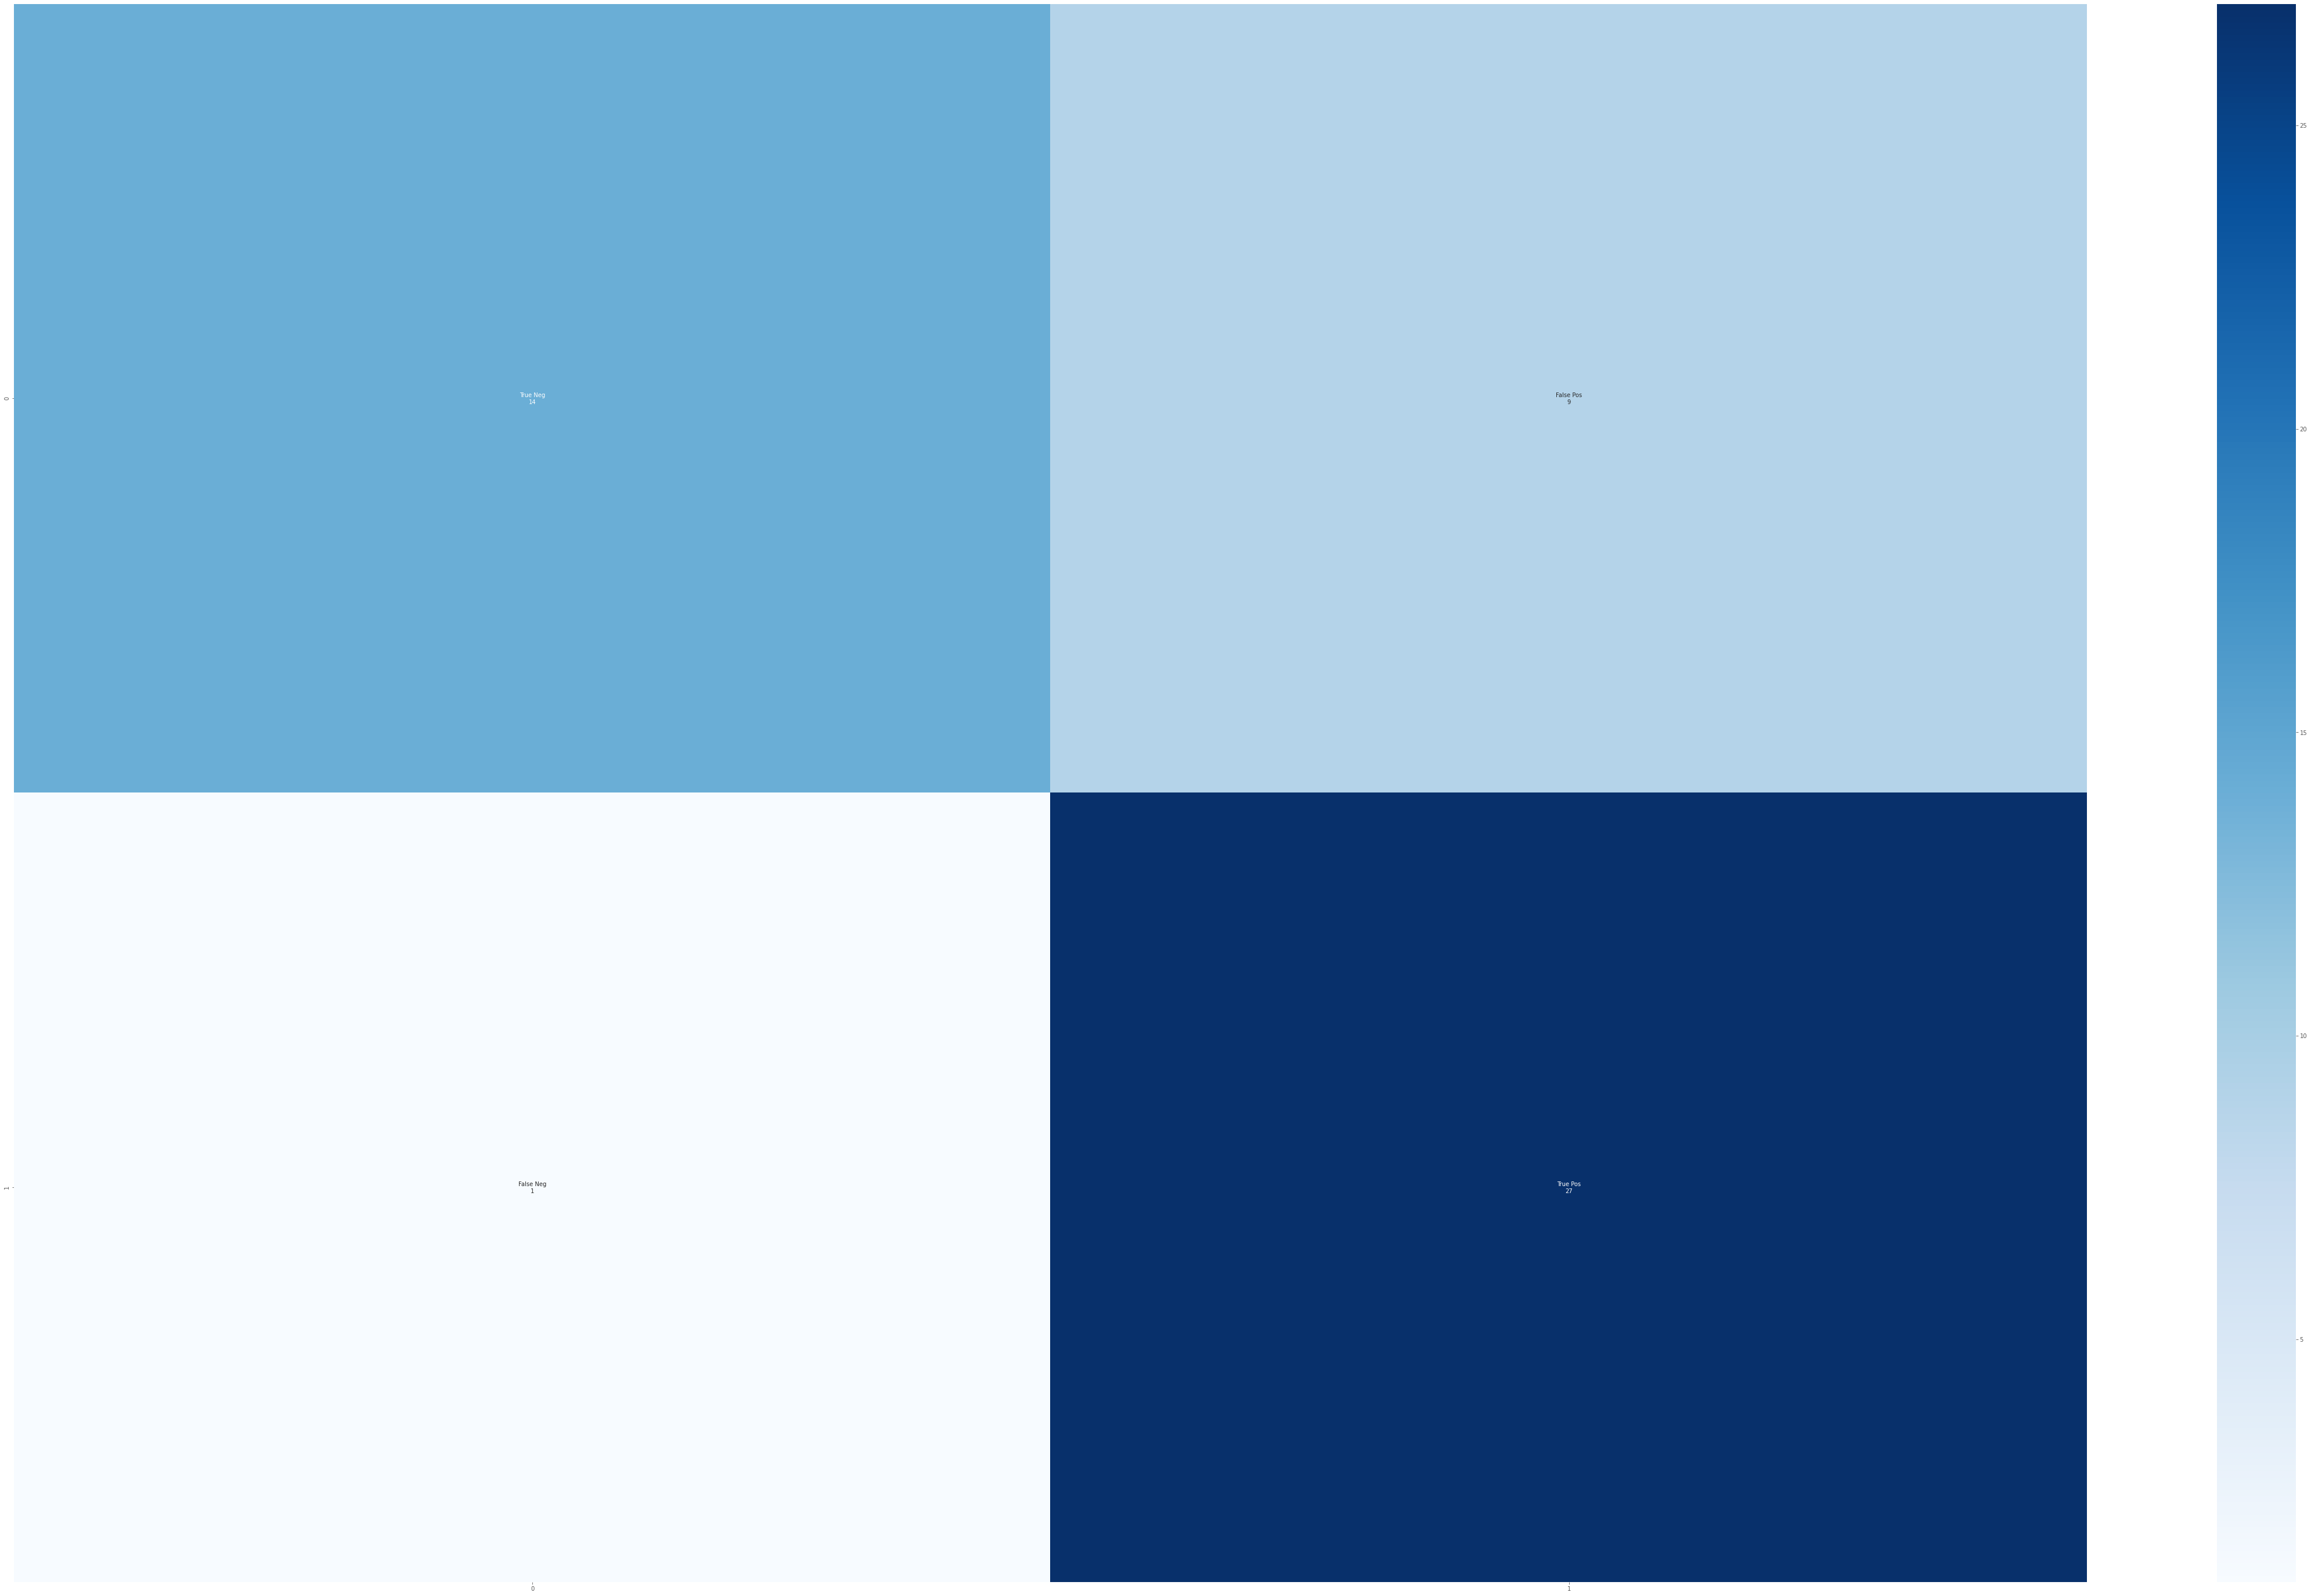

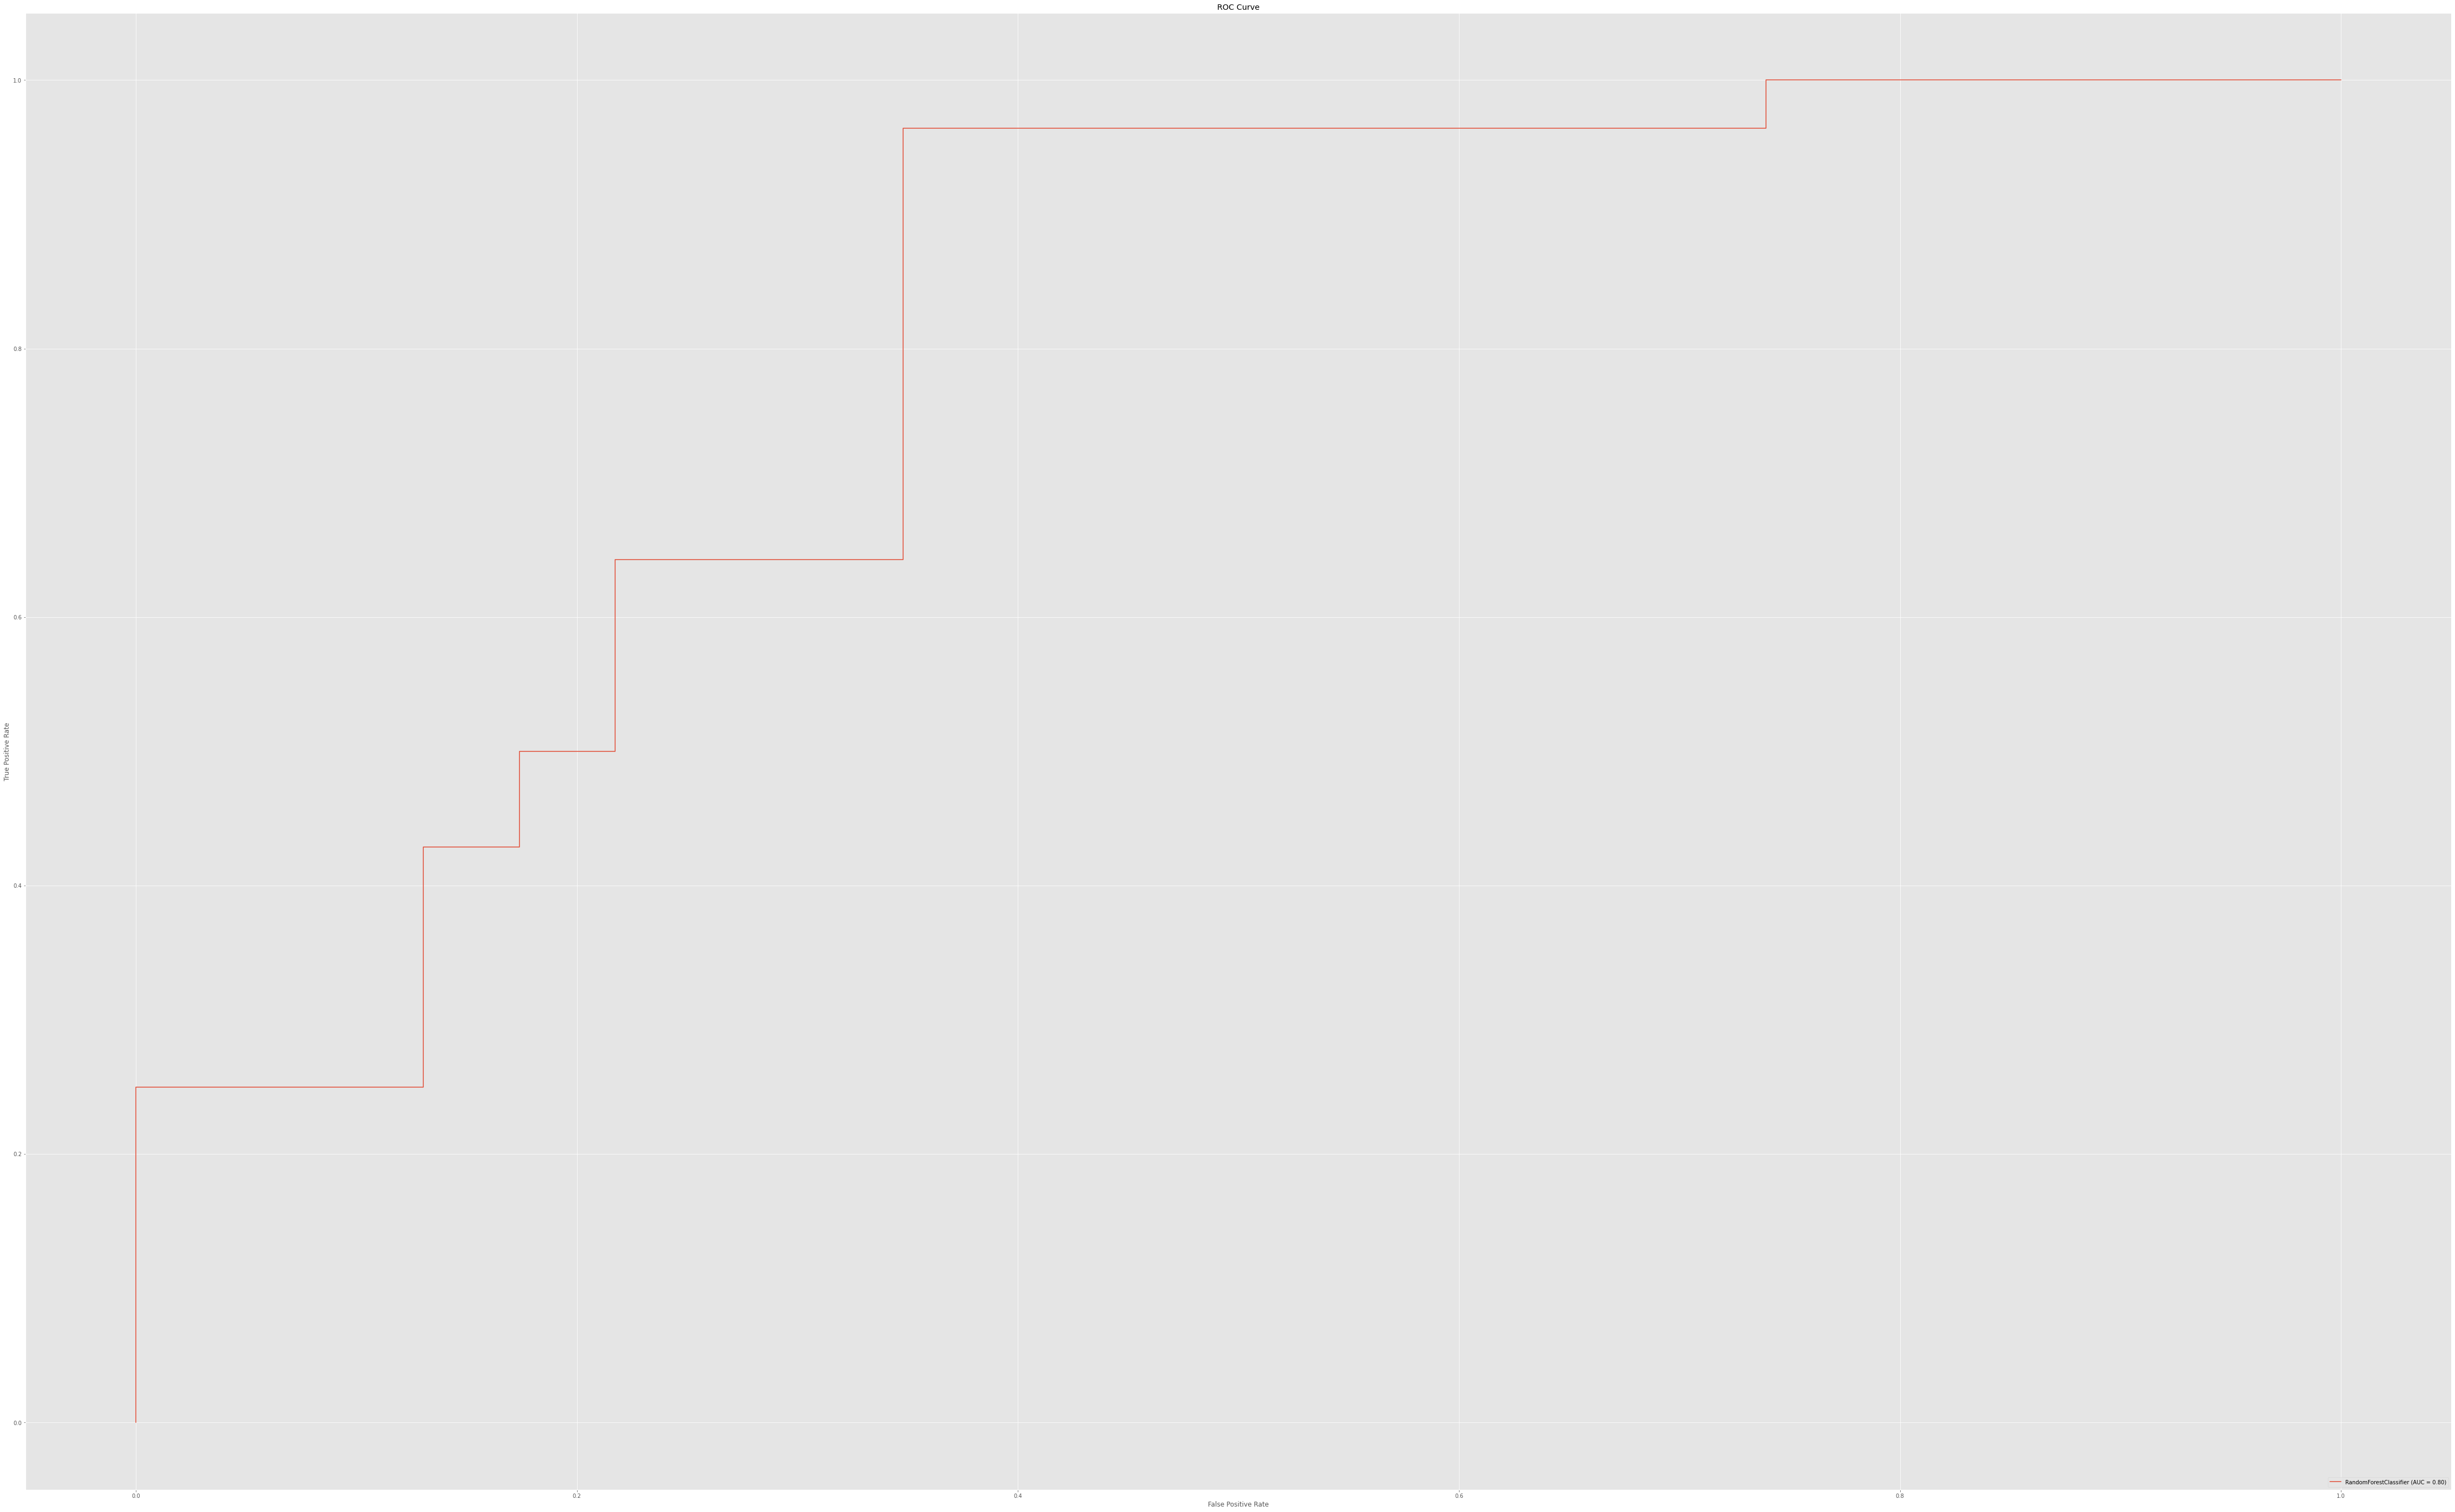

In [ ]:
rf2 = RandomForestClassifier(bootstrap = True ,
                             oob_score=True,
                            n_estimators = 100,
                            max_features = 0.7,
                            criterion='entropy', 
                            max_depth= 9, 
                            min_samples_split=10)
rf2.fit(X_train_scaled , y_train)
y_train_pred_rf2 = rf2.predict(X_train_scaled)
y_test_pred_rf2 = rf2.predict(X_test_scaled)

cm_rf = confusion_matrix(y_test, y_test_pred_rf2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_rf.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_rf,annot=labels,fmt='',cmap='Blues')
print()

TP_rf = cm_rf[1][1]
FP_rf = cm_rf[0][1]
FN_rf = cm_rf[1][0]
TN_rf = cm_rf[0][0] 

print('TP Rate : ',TP_rf / (TP_rf+FN_rf))
print('TN Rate : ', TN_rf/(FP_rf+TN_rf))
print('FP Rate : ', FP_rf/(FP_rf+TP_rf))
print('FN Rate : ', FN_rf/(FN_rf+TP_rf))
print('Success Rate: ', (TP_rf+TN_rf)/(TP_rf+FP_rf+FN_rf+TN_rf))
print('Misclassifiaction Rate: ', (FP_rf+FN_rf)/(TP_rf+FP_rf+FN_rf+TN_rf))

print(classification_report(y_test, y_test_pred_rf2))

print('OOB Score with hyperparameter tuning : ',(rf2.oob_score_)*100,'%')
print('Random Forest Test Accuracy : ',accuracy_score(y_test, y_test_pred_rf2)*100,'%')
print('Training Accuracy: ',accuracy_score(y_train, rf2.predict(X_train_scaled))*100,'%')

metrics.plot_roc_curve(rf2, X_test_scaled, y_test) 
plt.title('ROC Curve')
plt.show()

### 6.3 Boosting

#### 6.3.1 AdaBoost

In [ ]:
ada = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=100, random_state=42)
ada.fit(X_train_scaled,y_train)

print (f'Train Accuracy - : {ada.score(X_train_scaled,y_train):.3f}')
print (f'Test Accuracy - : {ada.score(X_test_scaled,y_test):.3f}')

Train Accuracy - : 1.000
Test Accuracy - : 0.765


In [ ]:
ada_params = {
    'n_estimators': [50,100,200],
    'learning_rate' : [0.1,0.01,0.001,0.2,0.3,0.4,0.5],
    'random_state' : [0,20,40]
    }
kfold = KFold(n_splits=10, random_state=21,shuffle=True)
ada_cv = RandomizedSearchCV(ada, ada_params, cv=kfold , verbose=1,n_jobs=-1)
ada_cv.fit(X_train_scaled,y_train)
print(ada_cv.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


{'random_state': 20, 'n_estimators': 100, 'learning_rate': 0.5}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished



TP Rate :  0.8571428571428571
TN Rate :  0.5652173913043478
FP Rate :  0.29411764705882354
FN Rate :  0.14285714285714285
Success Rate:  0.7254901960784313
Misclassifiaction Rate:  0.27450980392156865
              precision    recall  f1-score   support

         0.0       0.76      0.57      0.65        23
         1.0       0.71      0.86      0.77        28

    accuracy                           0.73        51
   macro avg       0.74      0.71      0.71        51
weighted avg       0.73      0.73      0.72        51

Random Forest Test Accuracy :  72.54901960784314 %
Training Accuracy:  100.0 %


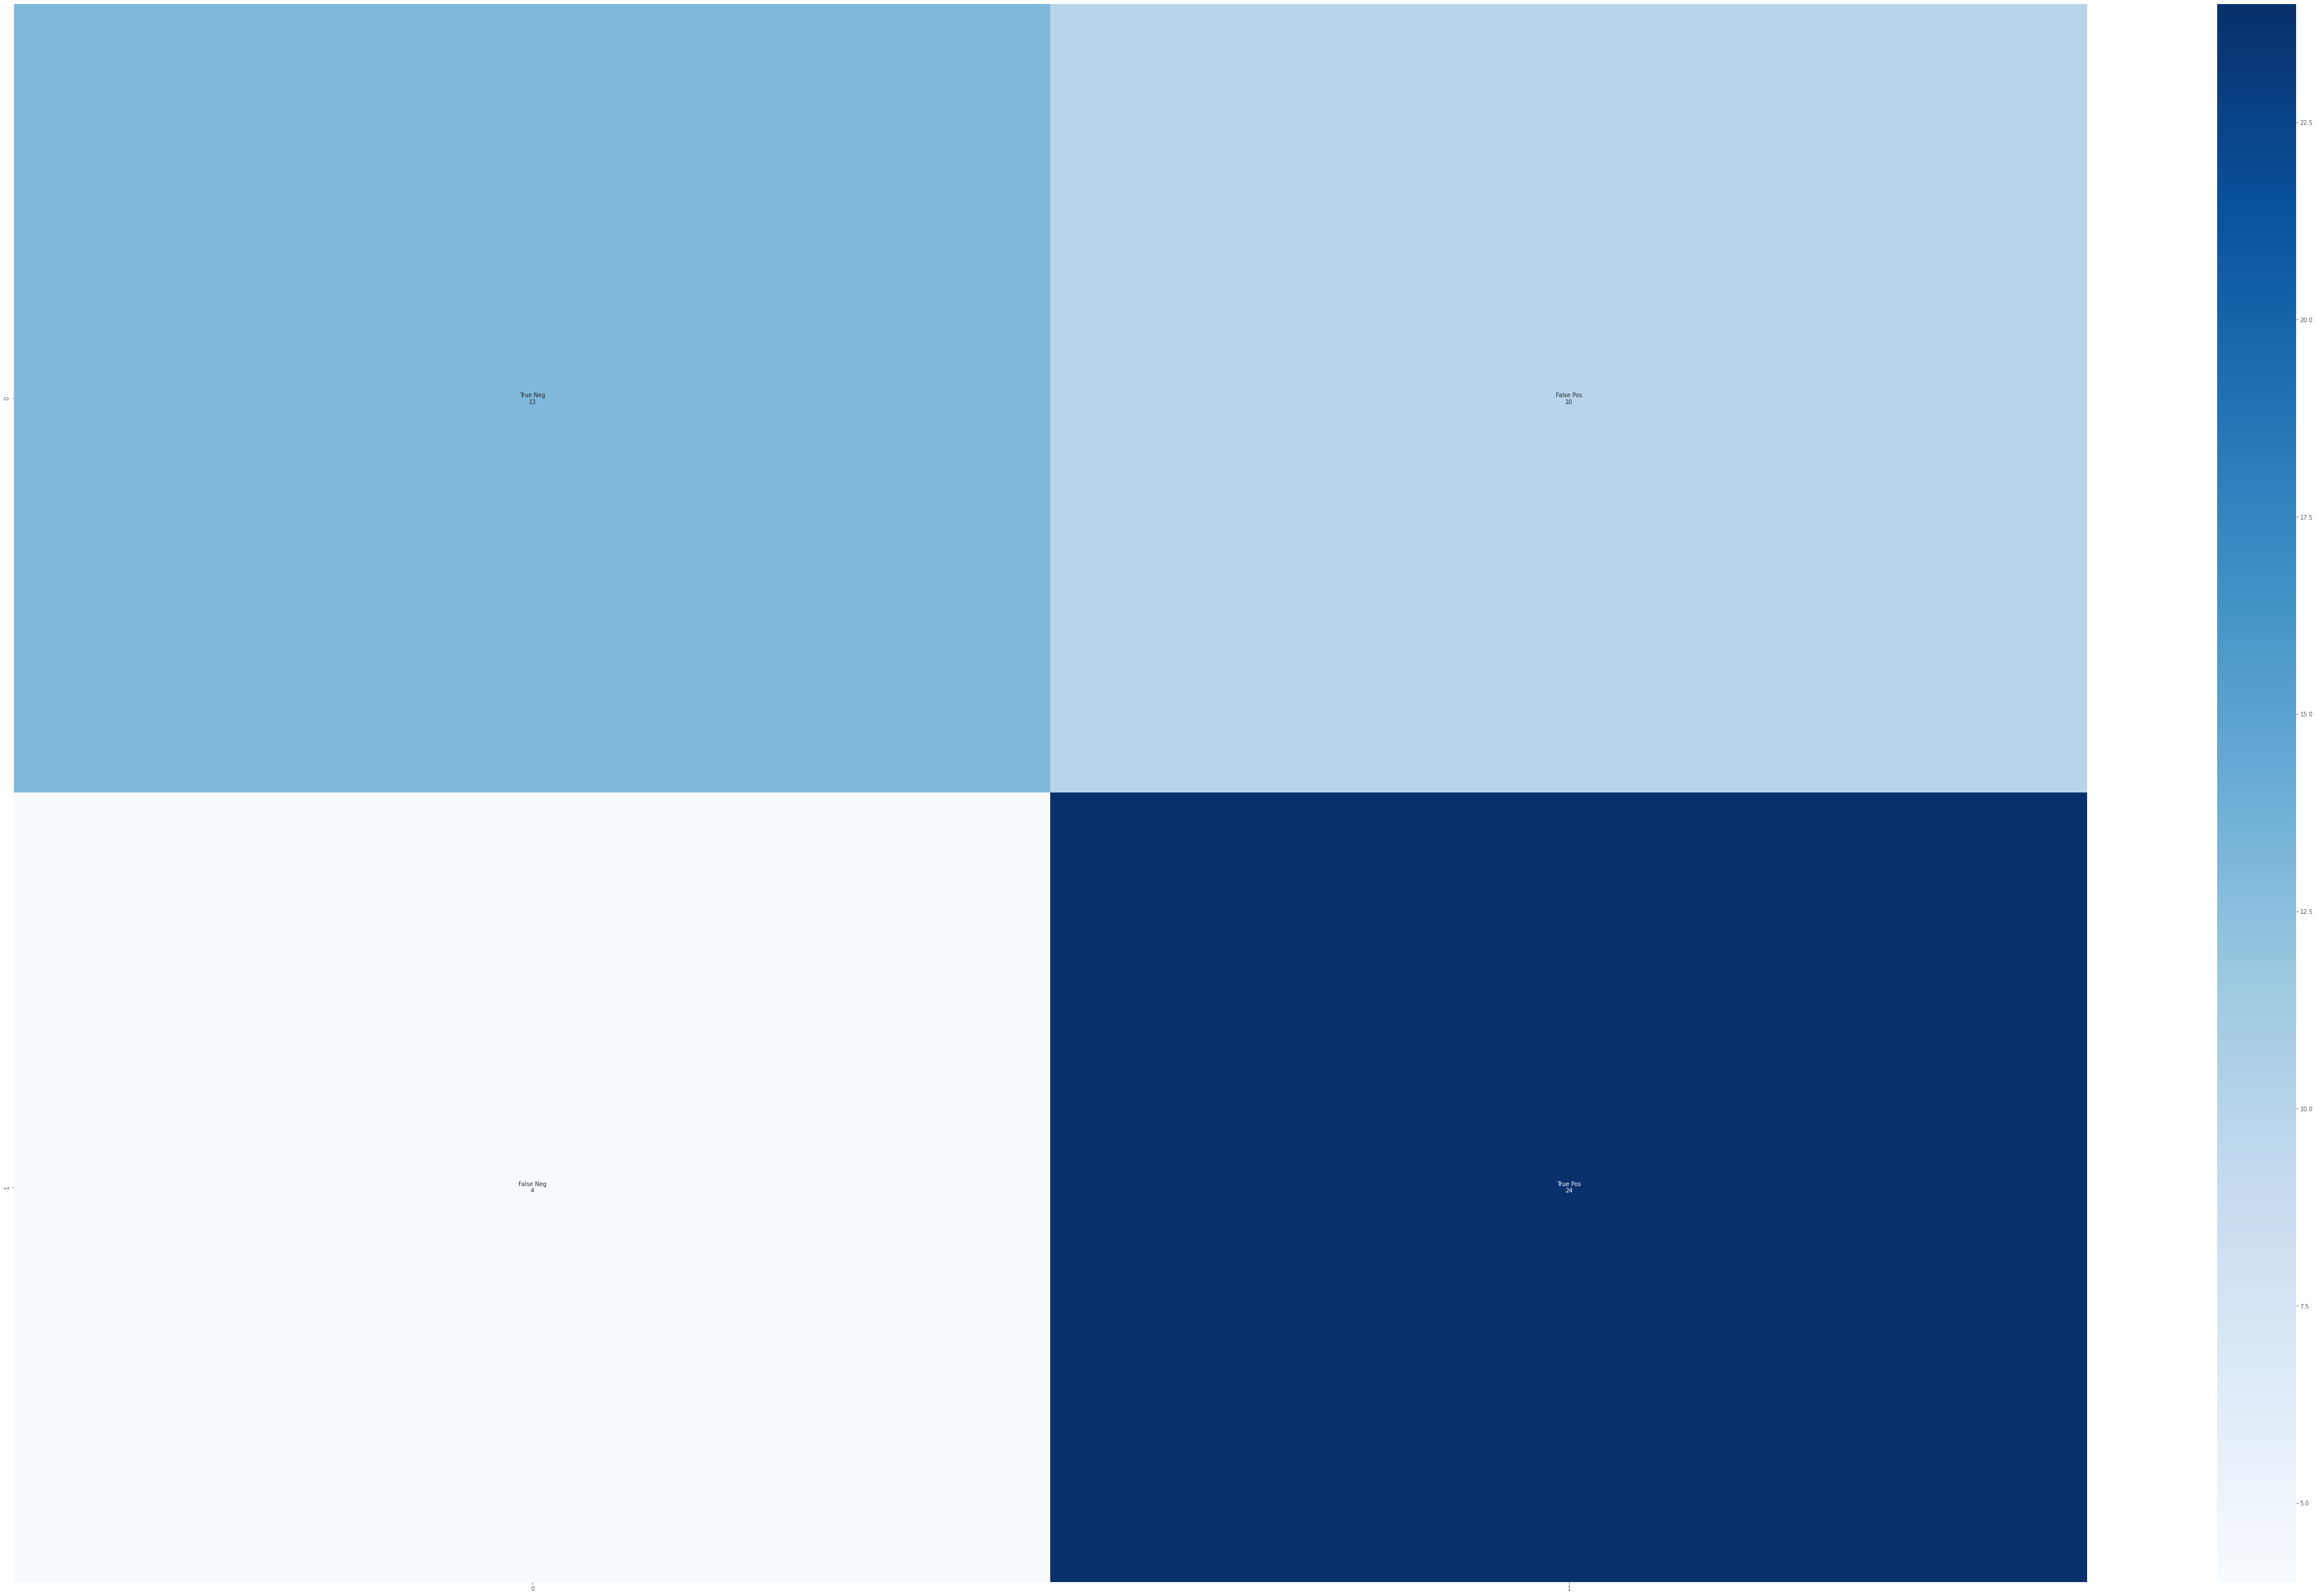

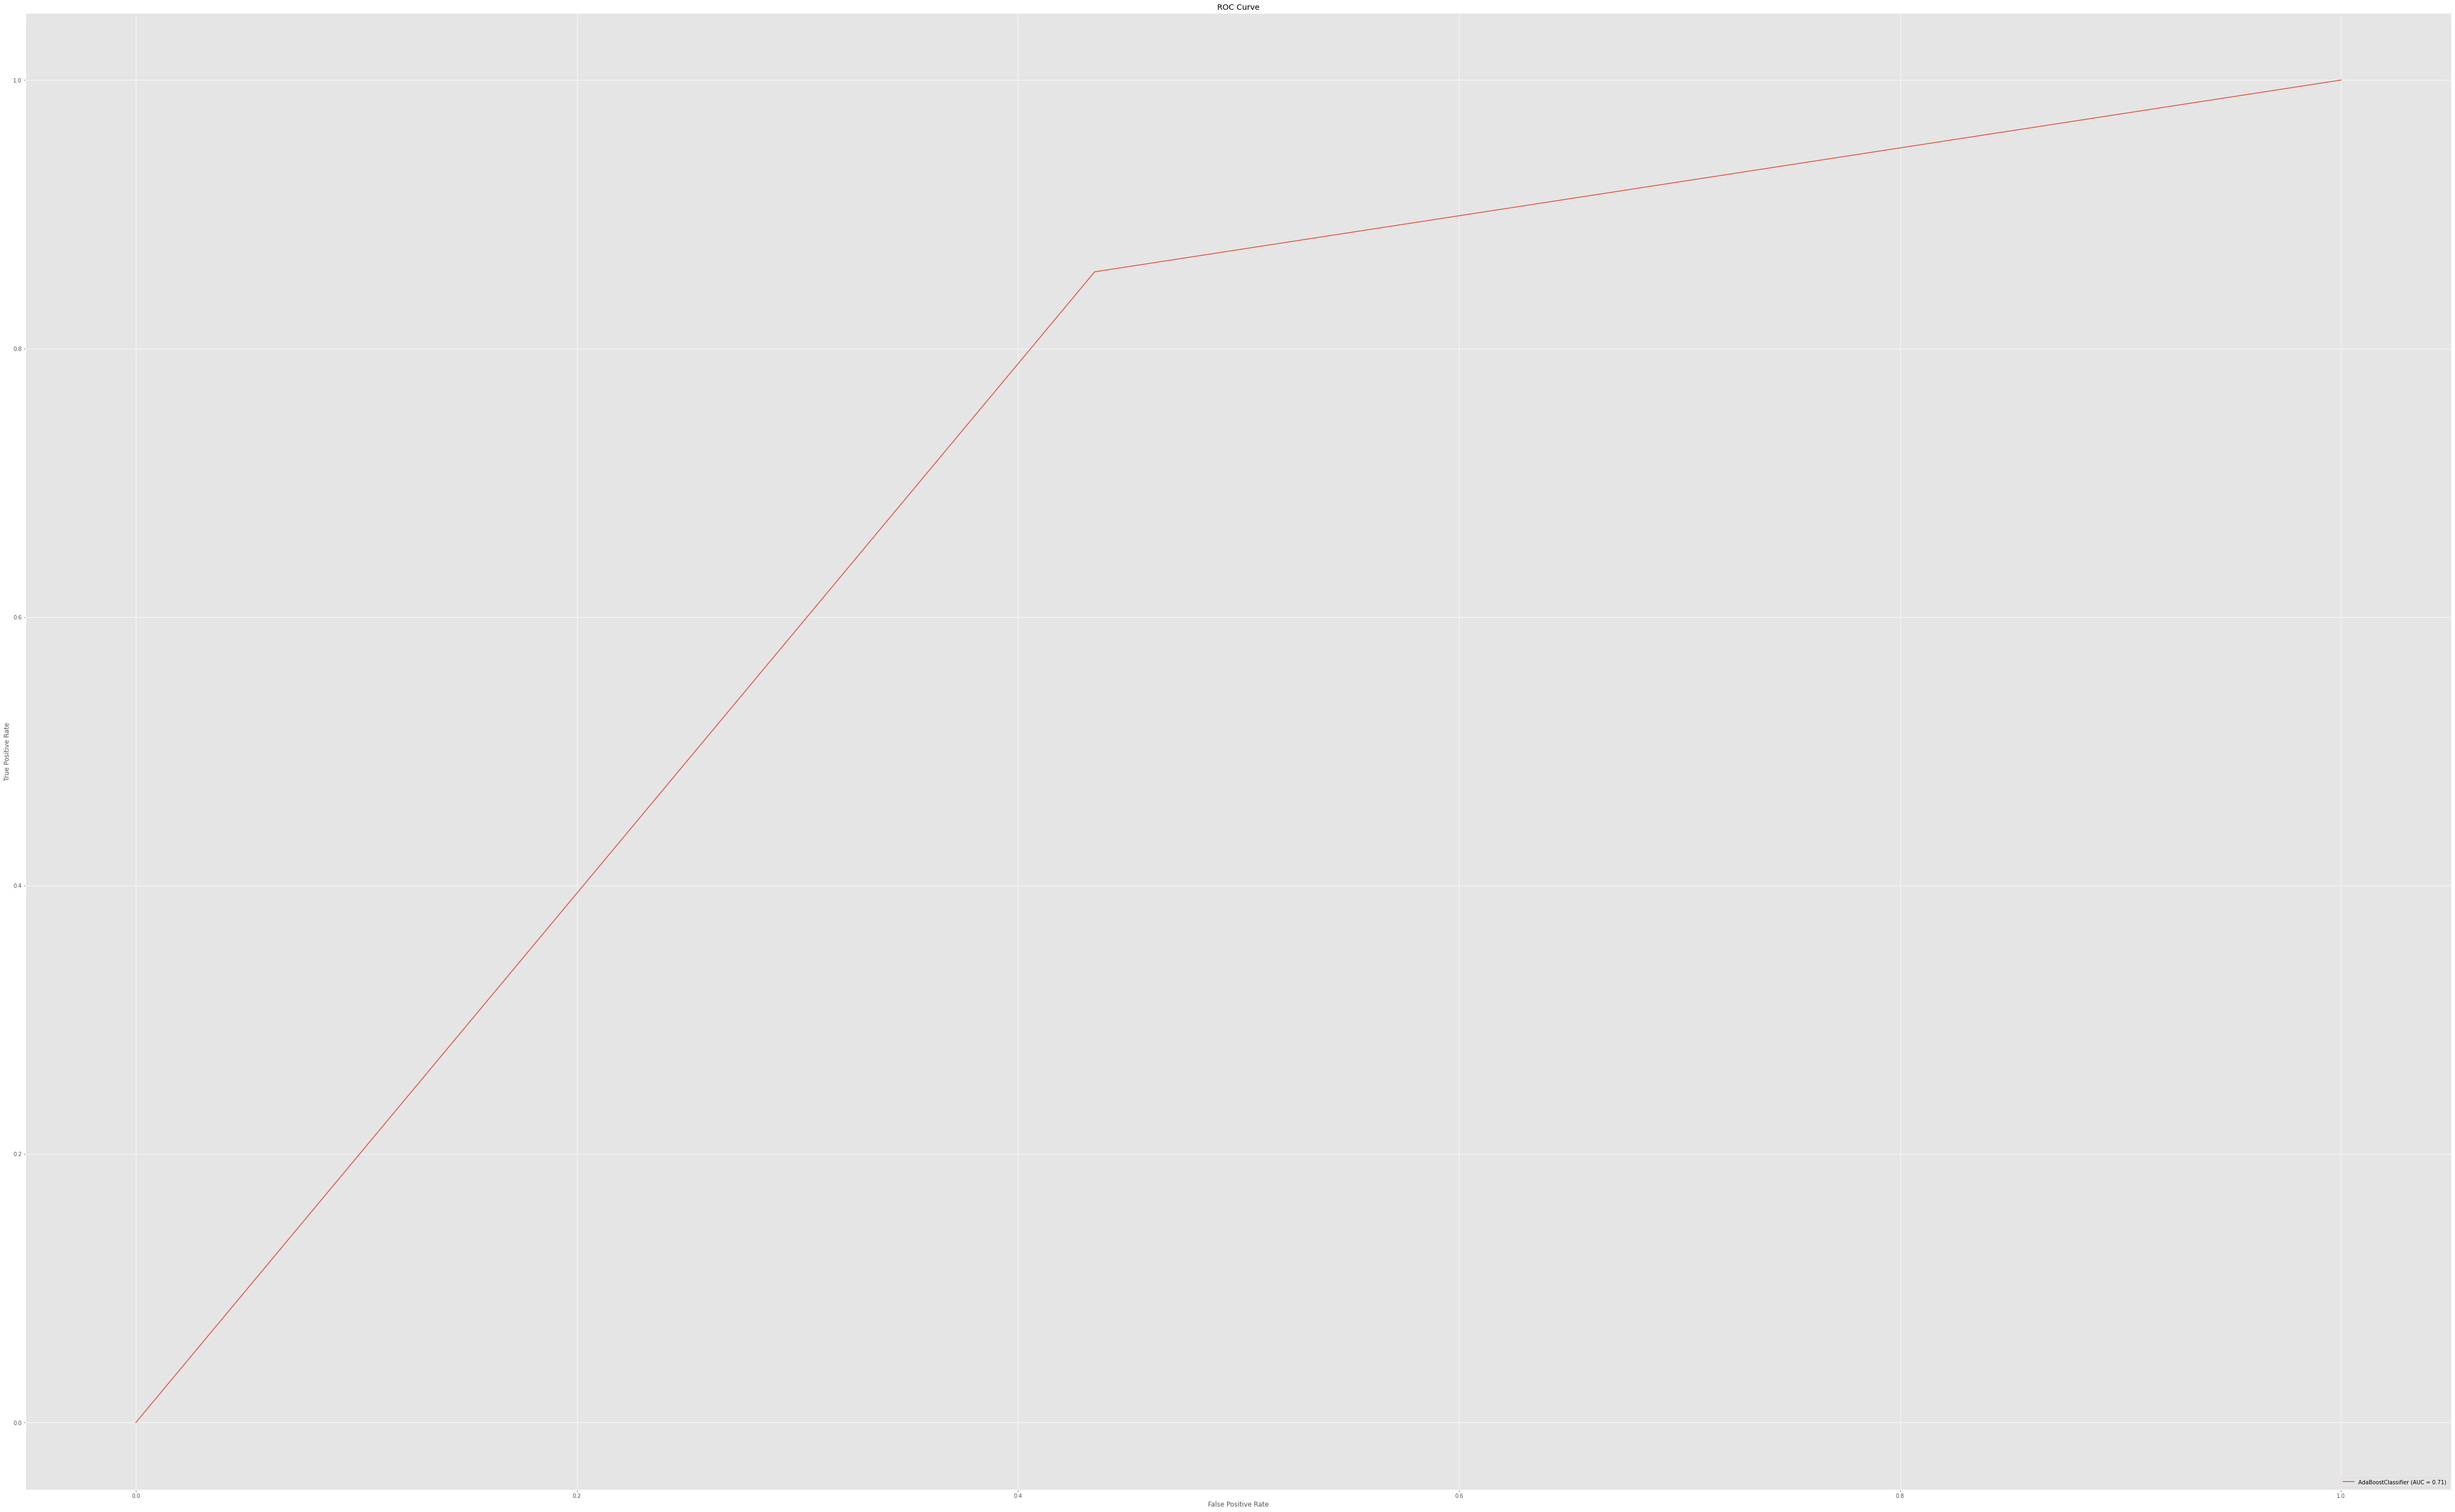

In [ ]:
ada2 = AdaBoostClassifier(ada,n_estimators=200, random_state=0,learning_rate=0.5)
ada2.fit(X_train_scaled,y_train)
y_pred_ada = ada2.predict(X_test_scaled)
cm_ab = confusion_matrix(y_test, y_pred_ada)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_ab.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_ab,annot=labels,fmt='',cmap='Blues')
print()

TP_ab = cm_ab[1][1]
FP_ab = cm_ab[0][1]
FN_ab = cm_ab[1][0]
TN_ab = cm_ab[0][0] 

print('TP Rate : ',TP_ab / (TP_ab+FN_ab))
print('TN Rate : ', TN_ab/(FP_ab+TN_ab))
print('FP Rate : ', FP_ab/(FP_ab+TP_ab))
print('FN Rate : ', FN_ab/(FN_ab+TP_ab))
print('Success Rate: ', (TP_ab+TN_ab)/(TP_ab+FP_ab+FN_ab+TN_ab))
print('Misclassifiaction Rate: ', (FP_ab+FN_ab)/(TP_ab+FP_ab+FN_ab+TN_ab))
print(classification_report(y_test, y_pred_ada))

print('Random Forest Test Accuracy : ',accuracy_score(y_test, y_pred_ada)*100,'%')
print('Training Accuracy: ',accuracy_score(y_train, ada2.predict(X_train_scaled))*100,'%')

metrics.plot_roc_curve(ada2, X_test_scaled, y_test) 
plt.title('ROC Curve')
plt.show()

## 7. Logistic Regression

In [ ]:
lr_clf = LogisticRegression()

param_grid = {
    'penalty' : ['l1' , 'l2'],
    'C' : [1,10,100,0.1,0.01,0.001]
}
grid_lr_clf = GridSearchCV(estimator=lr_clf,param_grid=param_grid,scoring='accuracy',verbose=1,n_jobs=-1,cv=kfold)
grid_lr_clf.fit(X_train_scaled,y_train)

grid_lr_clf.best_params_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished


{'C': 0.01, 'penalty': 'l2'}


TP Rate :  0.8571428571428571
TN Rate :  0.34782608695652173
FP Rate :  0.38461538461538464
FN Rate :  0.14285714285714285
Success Rate:  0.6274509803921569
Misclassifiaction Rate:  0.37254901960784315
              precision    recall  f1-score   support

         0.0       0.67      0.35      0.46        23
         1.0       0.62      0.86      0.72        28

    accuracy                           0.63        51
   macro avg       0.64      0.60      0.59        51
weighted avg       0.64      0.63      0.60        51

Logistic Regression Test Accuracy :  62.745098039215684 %
Training Accuracy:  74.75247524752476 %


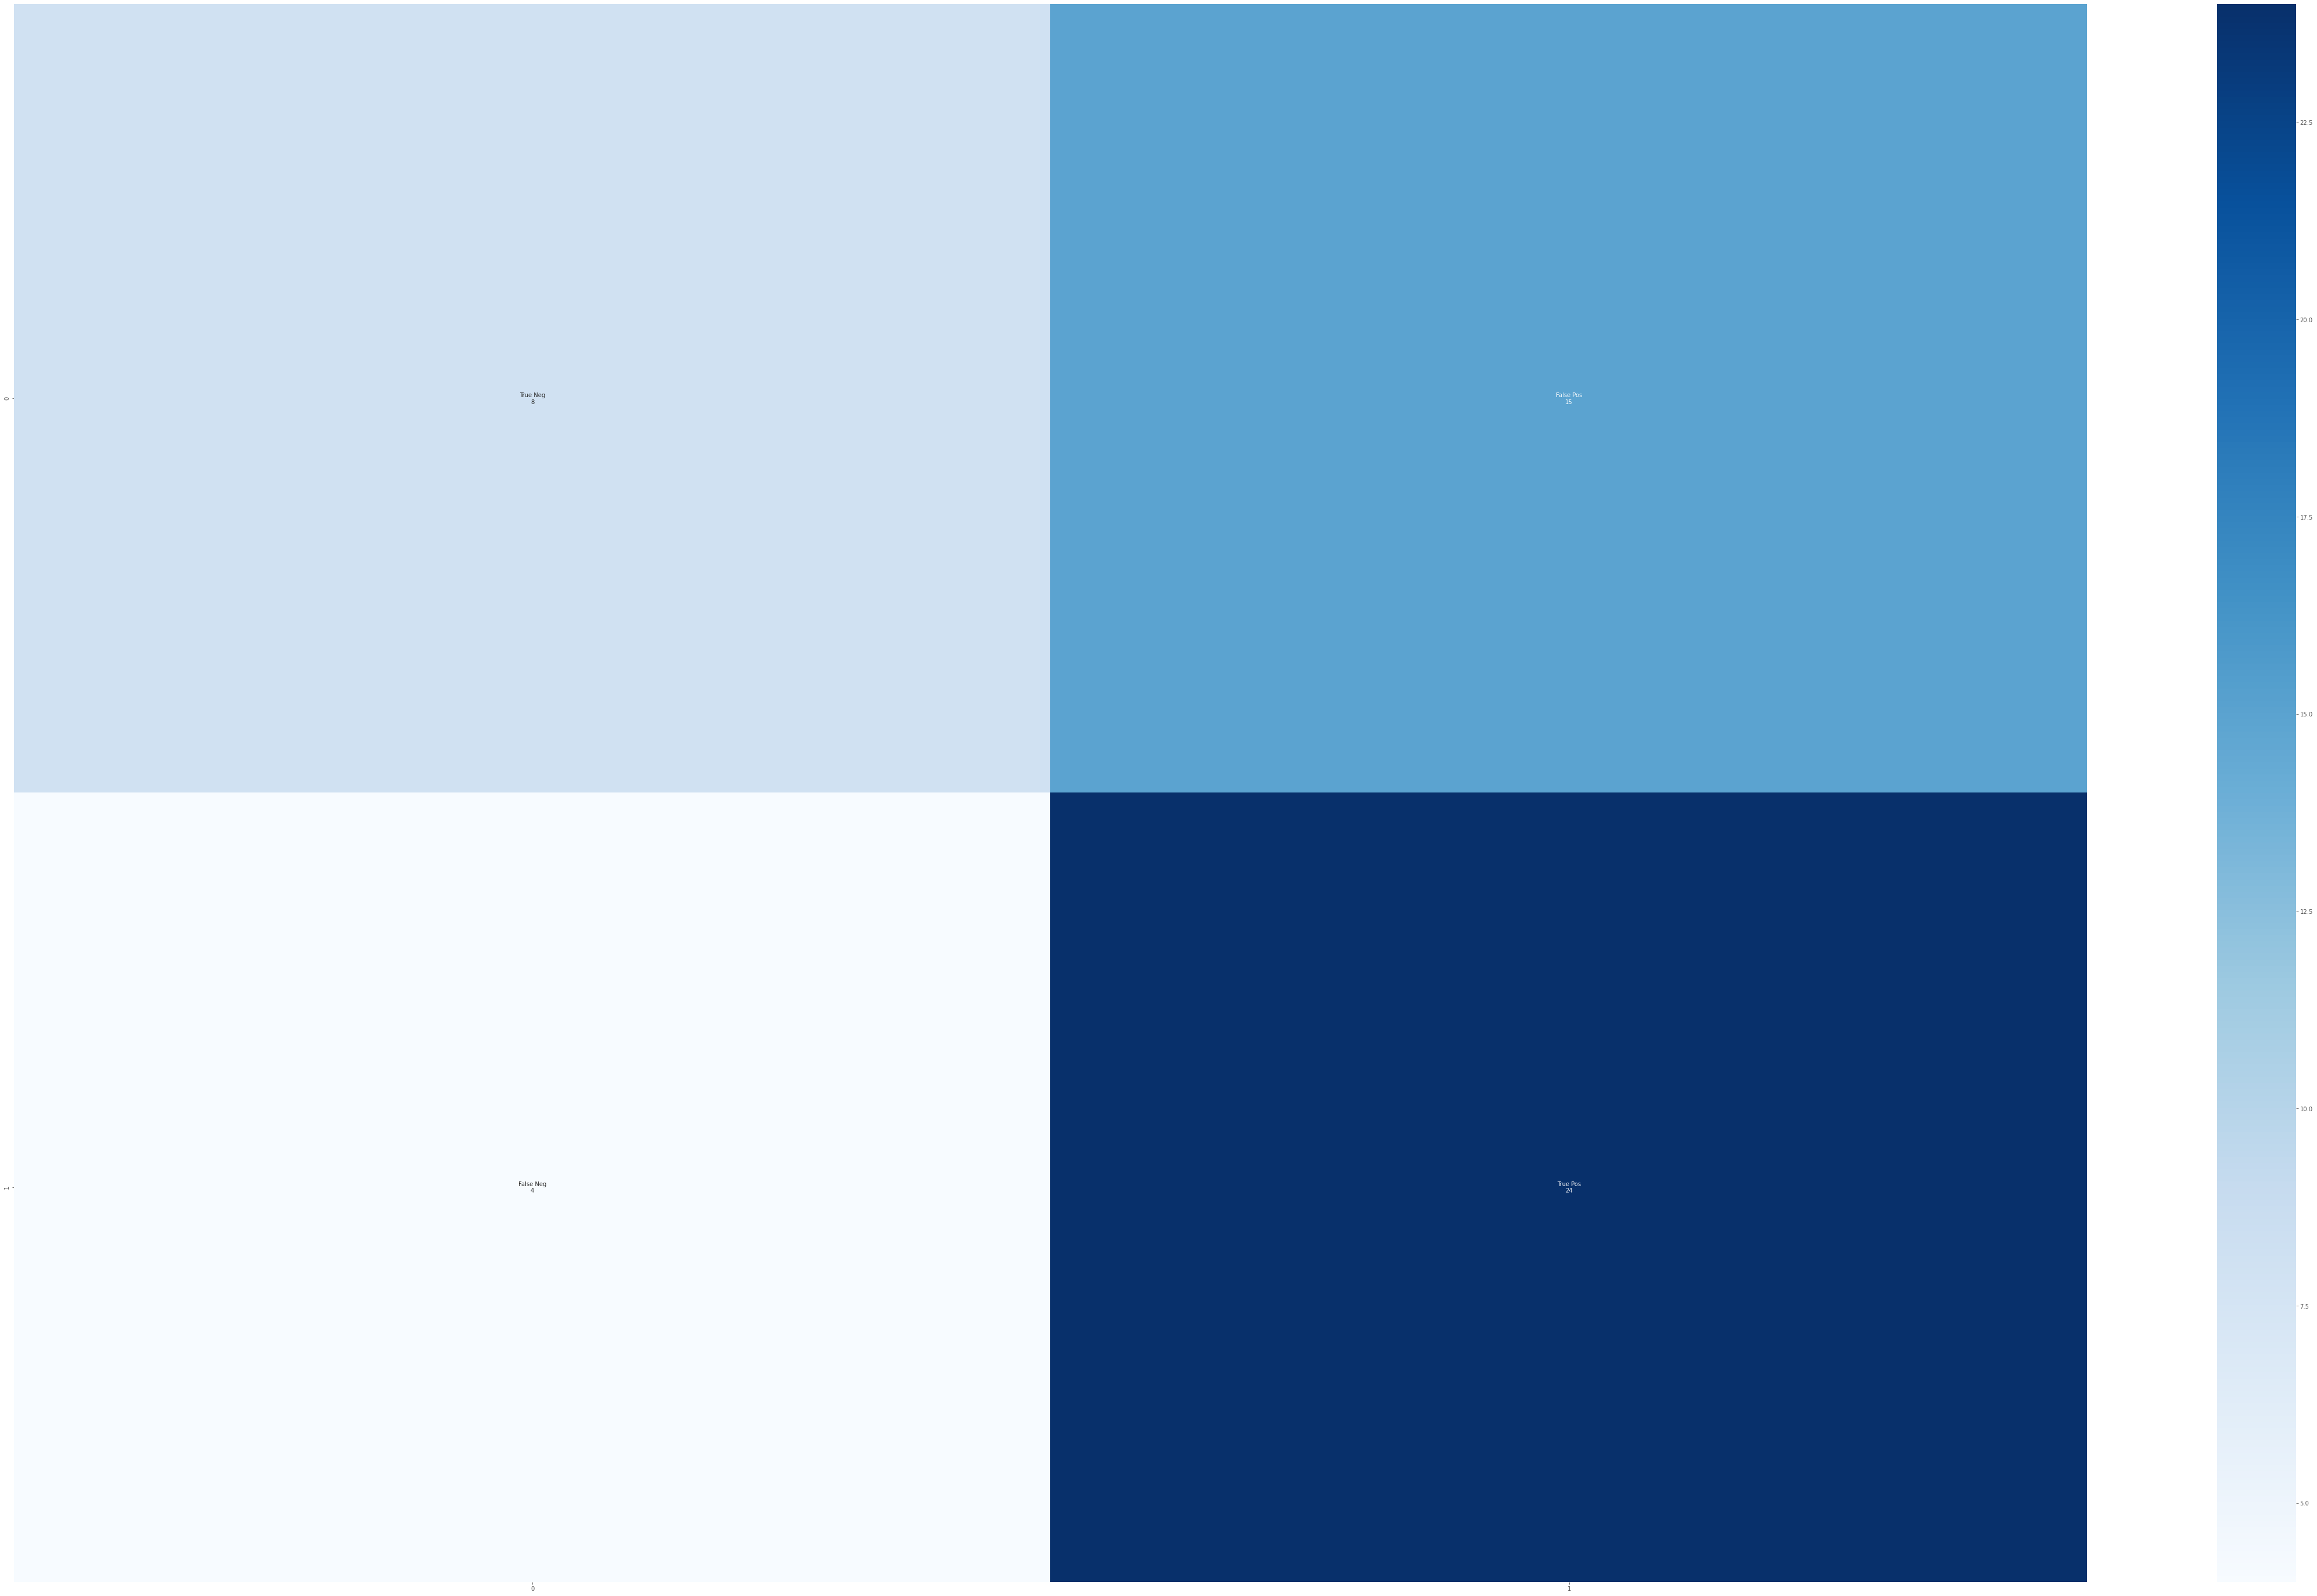

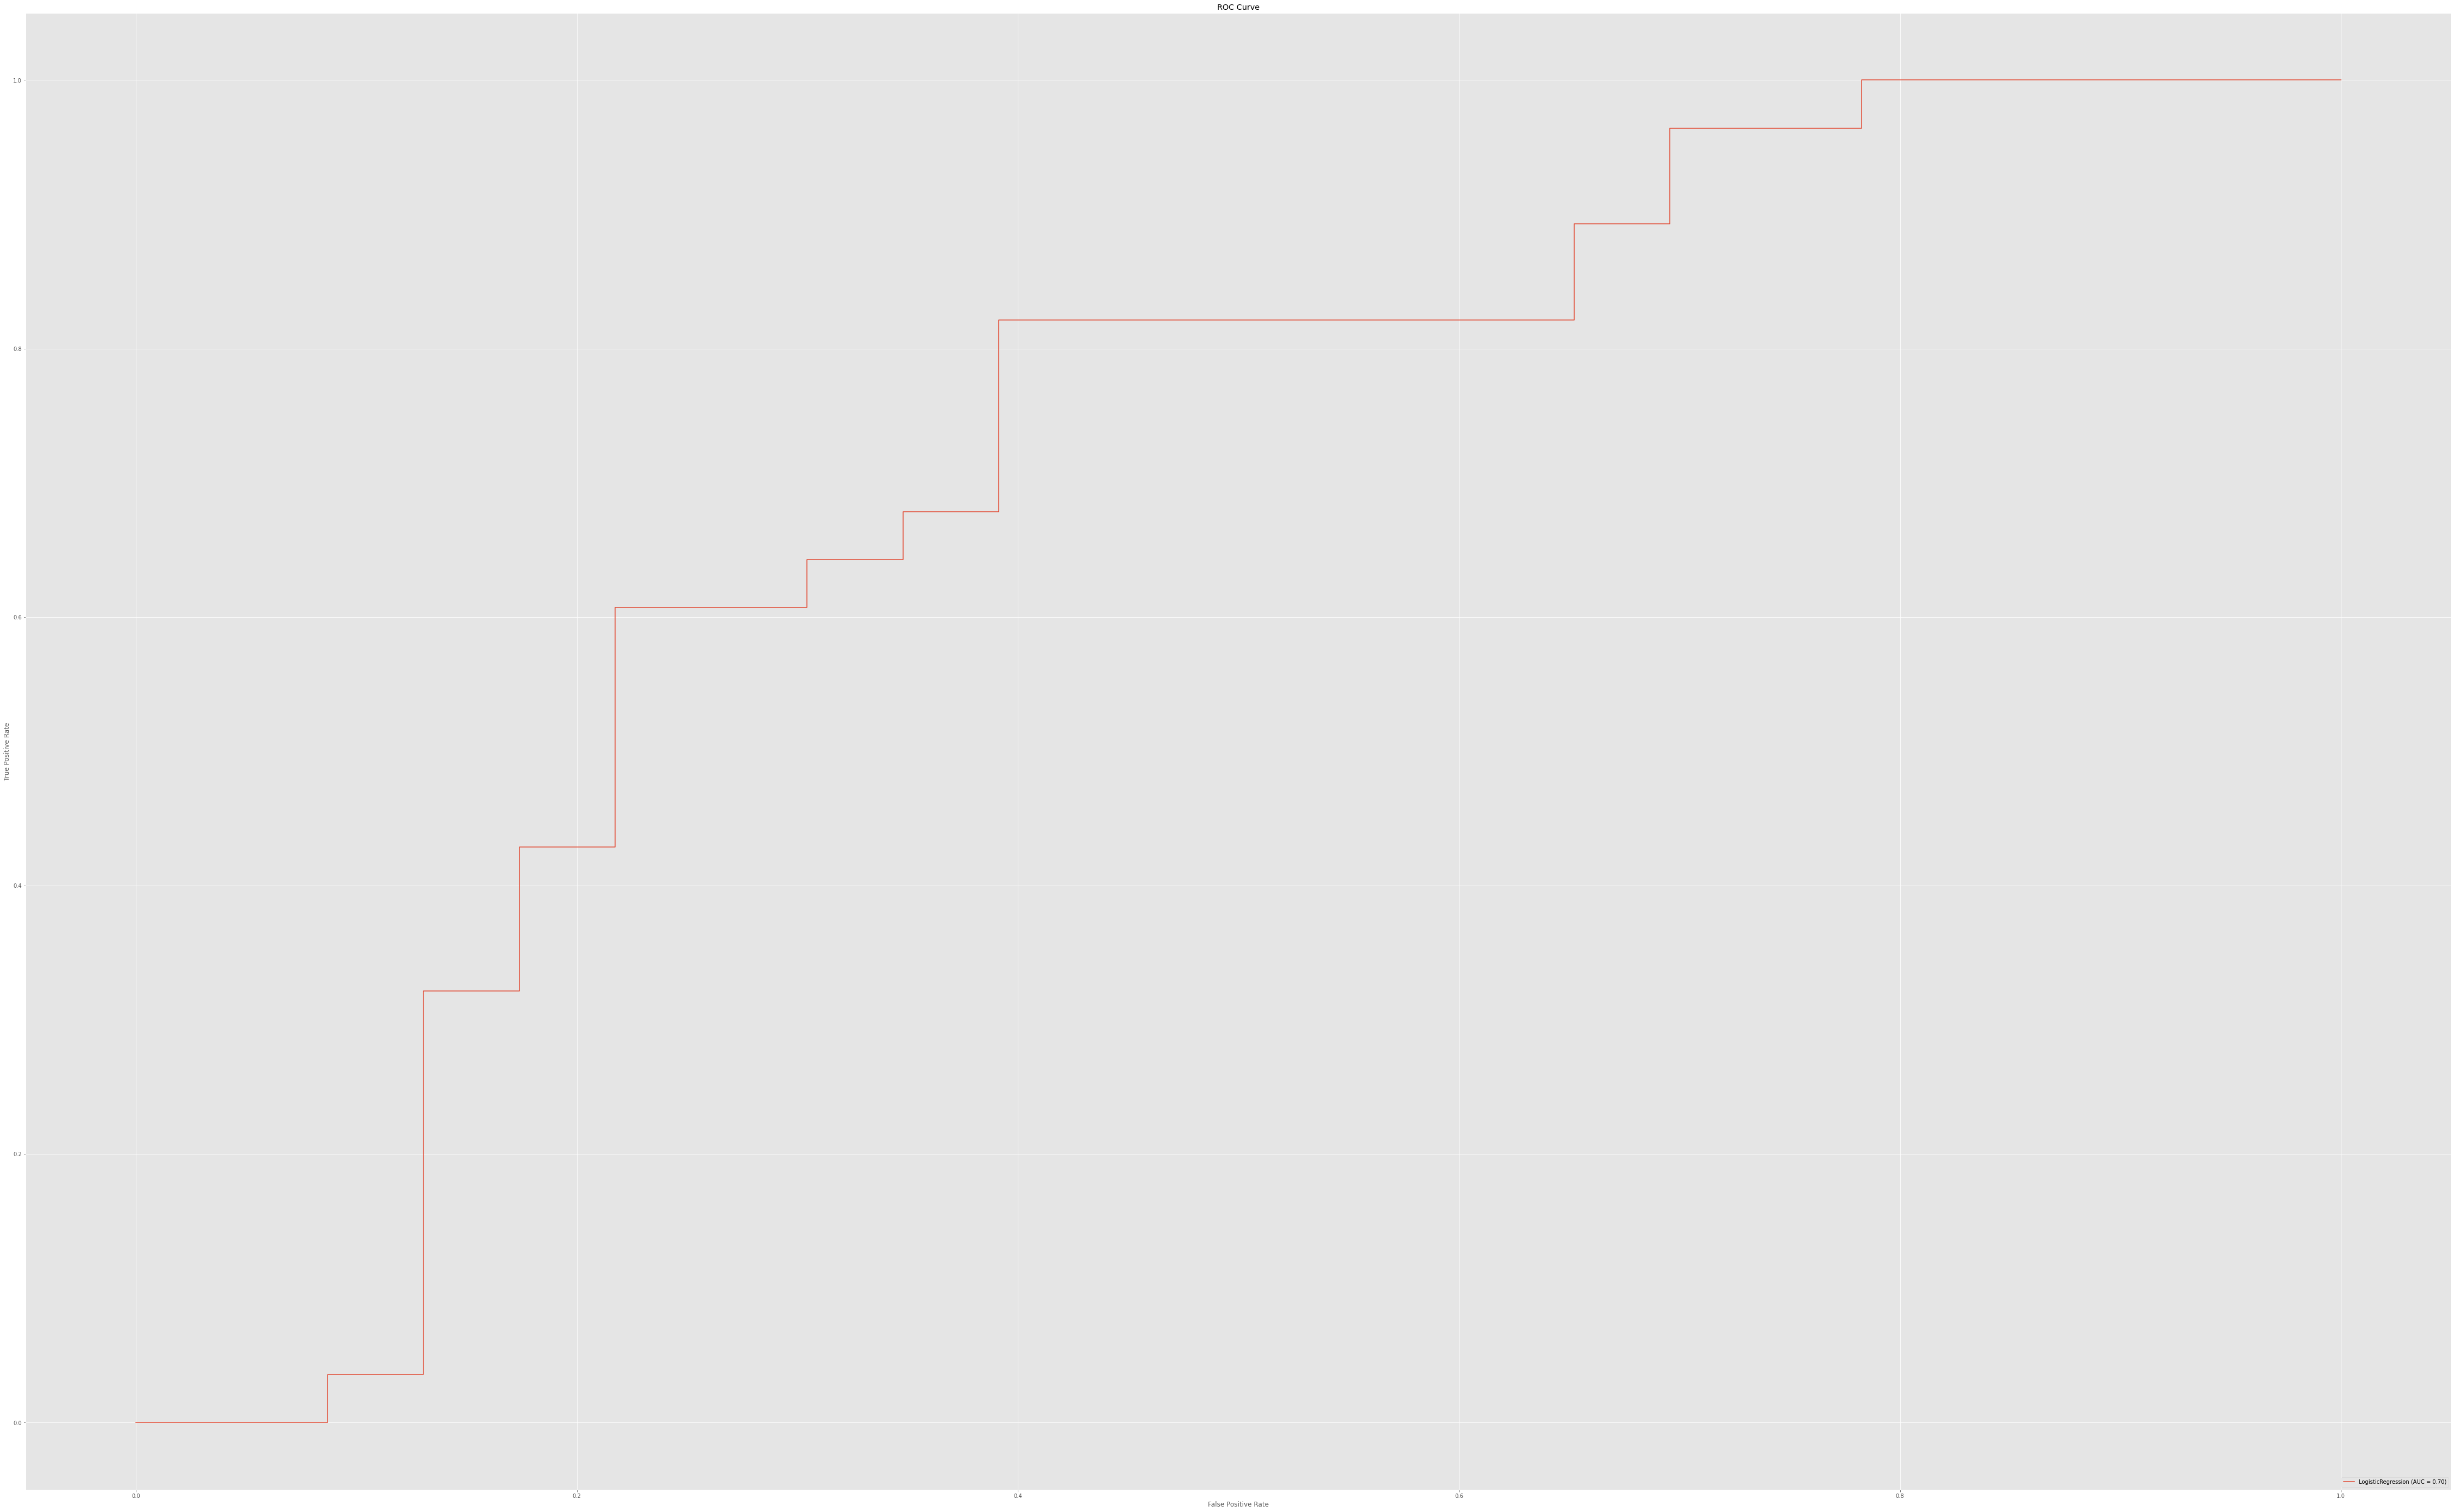

In [ ]:
lr_clf2 = LogisticRegression(C = 10 , penalty='l2',random_state=0)
lr_clf2.fit(X_train_scaled,y_train)
y_pred_lr = lr_clf2.predict(X_test_scaled)

cm_lr = confusion_matrix(y_test, y_pred_lr)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_lr.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_lr,annot=labels,fmt='',cmap='Blues')
print()

TP_lr = cm_lr[1][1]
FP_lr = cm_lr[0][1]
FN_lr = cm_lr[1][0]
TN_lr = cm_lr[0][0] 

print('TP Rate : ',TP_lr / (TP_lr+FN_lr))
print('TN Rate : ', TN_lr/(FP_lr+TN_lr))
print('FP Rate : ', FP_lr/(FP_lr+TP_lr))
print('FN Rate : ', FN_lr/(FN_lr+TP_lr))
print('Success Rate: ', (TP_lr+TN_lr)/(TP_lr+FP_lr+FN_lr+TN_lr))
print('Misclassifiaction Rate: ', (FP_lr+FN_lr)/(TP_lr+FP_lr+FN_lr+TN_lr))

print(classification_report(y_test, y_pred_lr))


print('Logistic Regression Test Accuracy : ',accuracy_score(y_test, y_pred_lr)*100,'%')
print('Training Accuracy: ',accuracy_score(y_train, lr_clf2.predict(X_train_scaled))*100,'%')

metrics.plot_roc_curve(lr_clf2, X_test_scaled, y_test) 
plt.title('ROC Curve')
plt.show()

In [ ]:
y_pred_prob = lr_clf2.predict_proba(X_test_scaled)[0:10]
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Non-Tumor (0)', 'Tumor (1)'])

y_pred_prob_df.head()



,Non-Tumor (0),Tumor (1)
0,0.26,0.74
1,0.43,0.57
2,0.26,0.74
3,0.45,0.55
4,0.04,0.96


Text(0, 0.5, 'Frequency')

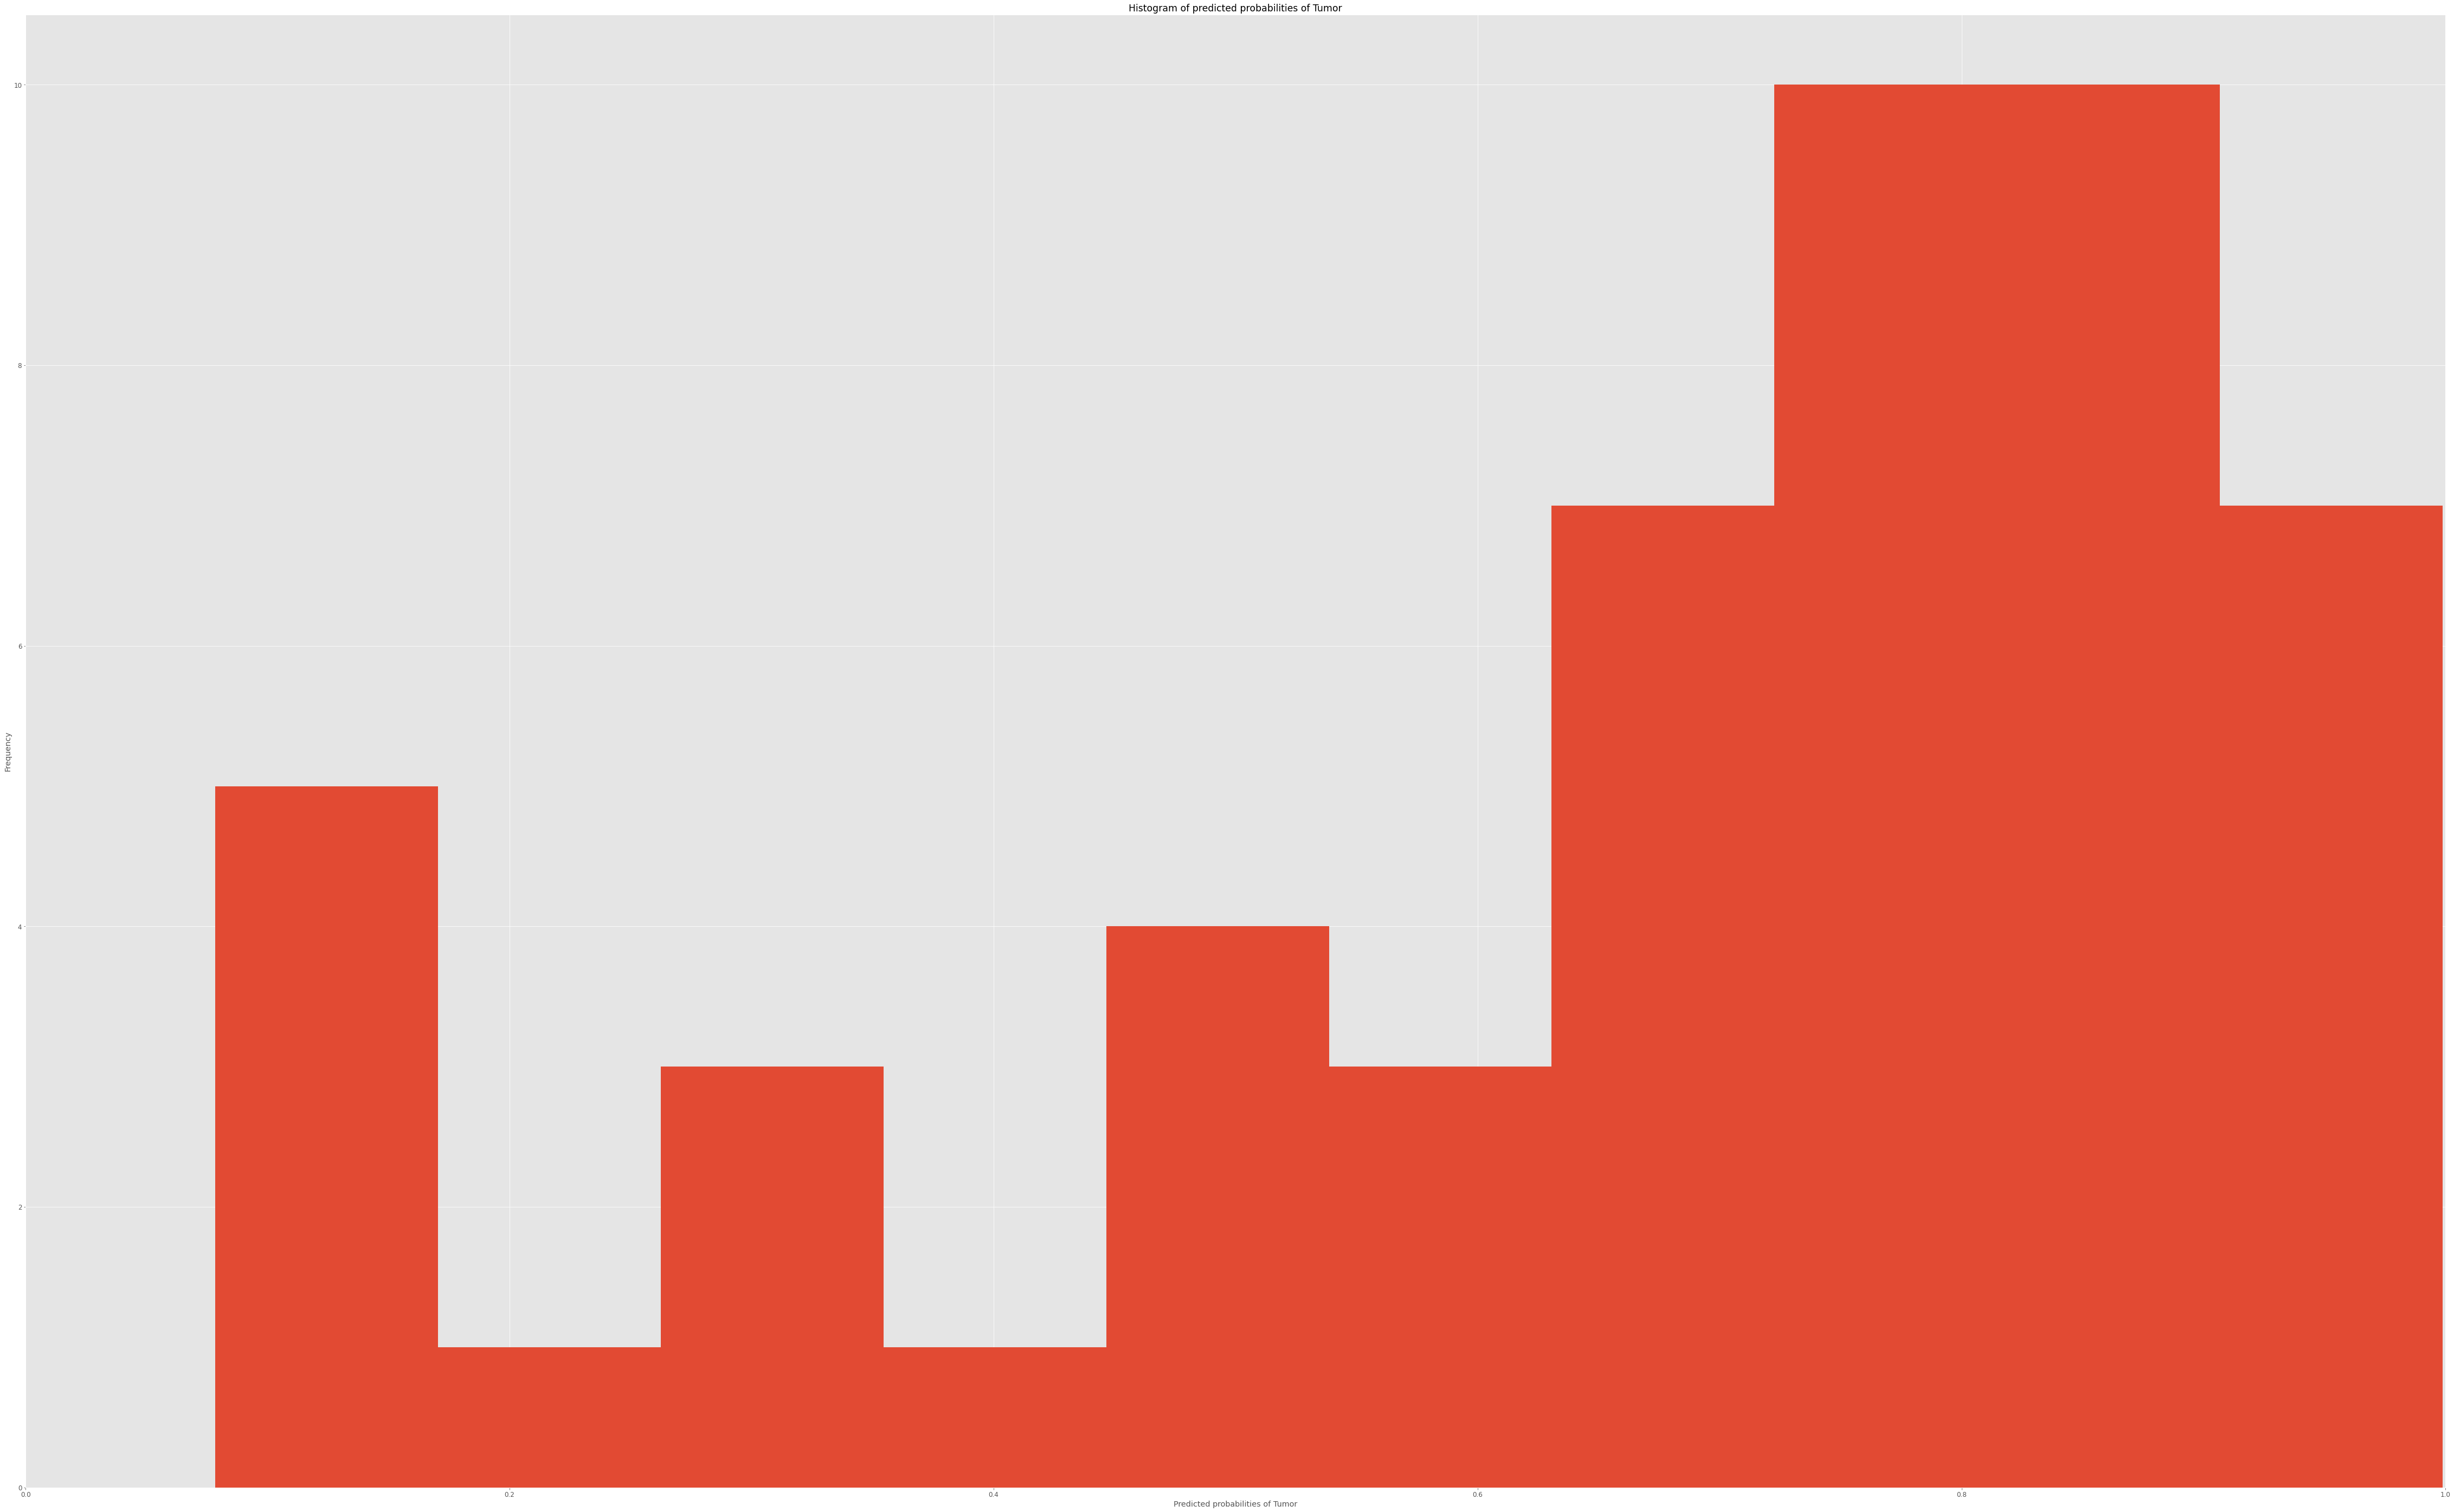

In [ ]:
y_pred1 = lr_clf2.predict_proba(X_test_scaled)[:, 1]
plt.rcParams['font.size'] = 12
plt.hist(y_pred1, bins = 10)

plt.title('Histogram of predicted probabilities of Tumor')

plt.xlim(0,1)

plt.xlabel('Predicted probabilities of Tumor')
plt.ylabel('Frequency')

# Comparing Different Models

sensitivity = tp/total pos
specificity = tn/total neg

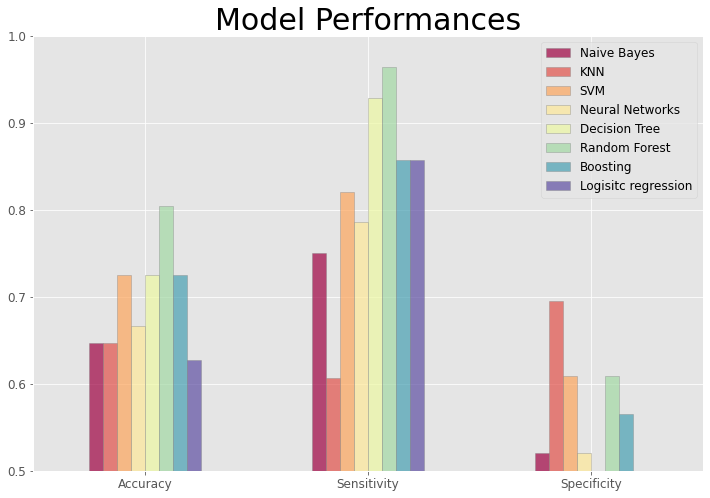

In [ ]:
models_metrics = {'Naive Bayes': [ 0.6470588235294117, 0.75, 0.52], 
                 'KNN': [ 0.6470588235294117, 0.6071, 0.69565],
                 'SVM' : [0.7254901960784314,0.82,0.60869],
                 'Neural Networks' : [0.6666666666666666,0.7857,0.52],
                  'Decision Tree' : [0.7254901960784314,0.92857,0.47826],
                  'Random Forest' : [0.803921568627451,0.9642857,0.60869],
                  'Boosting' : [ 0.7254901960784314,0.857,0.5652],
                  'Logisitc regression' : [0.62745098039215684 ,0.857,0.3478]
                }
df_compare = pd.DataFrame(data = models_metrics)
df_compare.rename(index={0:'Accuracy',1:'Sensitivity', 2: 'Specificity'}, 
                 inplace=True)
ax = df_compare.plot(kind='bar', figsize = (12,8), ylim = (0.50, 1), 
        colormap='Spectral',
        rot = 0, 
        edgecolor = 'grey', alpha = 0.7,)

plt.title('Model Performances',fontsize=30,color='black')
plt.show()